In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
sys.path.insert(0,'/Users/weilu/Research/opt_server/')
# from notebookFunctions import *
# from .. import notebookFunctions

from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from Bio.PDB.Polypeptide import d1_to_index
from Bio.PDB.Polypeptide import dindex_to_1
from Bio.PDB.Polypeptide import aa3

In [3]:
plt.rcParams['figure.figsize'] = [16.18033, 10]    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100

In [4]:
def get_interaction_data(structure):
    # get all the pair of interaction, direct and mediated. as a dataFrame.
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    sequence = get_sequence_from_structure(structure)
    cb_density = calculate_cb_density(res_list, neighbor_list)
    r_min_direct = 2.5
    r_max_direct = 6.5
    r_min = 6.5
    r_max = 9.5
    kappa = 5.0
    min_seq_sep = 10
    density_threshold = 2.6
    density_kappa = 7.0
    # phi_mediated_contact_well = np.zeros((2, 20,20))
    v_mediated = 0
    data_ = []
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        rho_i = cb_density[res1globalindex]
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)
            rho_j = cb_density[res2globalindex]

            # if res2globalindex - res1globalindex >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
            if abs(res2globalindex - res1globalindex) >= min_seq_sep or (res1chain != res2chain):
                if res1.resname == res2.resname:
                    if not (res2globalindex - res1globalindex >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex)):
                        continue
                res1type = get_res_type(res_list, res1)
                res2type = get_res_type(res_list, res2)
                rij = get_interaction_distance(res1, res2)
                theta = interaction_well(rij, r_min, r_max, kappa)
                water_theta = prot_water_switchFunc_sigmaWater(rho_i, rho_j, density_threshold, density_kappa) * theta
                protein_theta = prot_water_switchFunc_sigmaProt(rho_i, rho_j, density_threshold, density_kappa) * theta
                data_.append([res1.resname, res2.resname, "Protein", round(protein_theta, 3), res1globalindex, res2globalindex, rij, res1index, res2index])
                data_.append([res1.resname, res2.resname, "Water", round(water_theta, 3), res1globalindex, res2globalindex, rij, res1index, res2index])
                direct_theta = interaction_well(rij, r_min_direct, r_max_direct, kappa)
                data_.append([res1.resname, res2.resname, "Direct", round(direct_theta, 3), res1globalindex, res2globalindex, rij, res1index, res2index])
                # protein_gamma = protein_gamma_ijm[0][res1type][res2type]*k_hypercharge
                # water_gamma = water_gamma_ijm[0][res1type][res2type]*k_hypercharge
    data = pd.DataFrame(data_, columns=["Res1", "Res2", "Type", "Theta", "Index1", "Index2", "r", "ResId1", "ResId2"])

    # contact_gammas["Res1"] = contact_gammas.apply(lambda x: one_to_three(x["Res1"]), axis=1)
    # contact_gammas["Res2"] = contact_gammas.apply(lambda x: one_to_three(x["Res2"]), axis=1)
    # contact_gammas["Type"] = contact_gammas["Interaction"]
    # a = data.merge(contact_gammas, on=["Res1", "Res2", "Type"])
    # a["theta_gamma"] = a["Theta"] * a["Gamma"]
    return data


def get_contact_gamma_info(gammaFile):
    # check the gamma.
    # read in gamma, and sort by size.
    # gammaFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_optimization/optimization_new_4_withoutBurial/saved_gammas/new_4_cutoff600_impose_Aprime_constraint"
    gamma = np.loadtxt(gammaFile)

    res_type_map_letters = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G',
                            'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

    inverse_res_type_map = dict(list(zip(list(range(20)), res_type_map_letters)))
    c = 0
    info_ = []
    for i in range(20):
        for j in range(i, 20):
            info_.append(["Direct", res_type_map_letters[i], res_type_map_letters[j], c, round(gamma[c],3)])
            if i != j:
                info_.append(["Direct", res_type_map_letters[j], res_type_map_letters[i], c, round(gamma[c],3)])
            c += 1
    for i in range(20):
        for j in range(i, 20):
            info_.append(["Protein", res_type_map_letters[i], res_type_map_letters[j], c, round(gamma[c],3)])
            if i != j:
                info_.append(["Protein", res_type_map_letters[j], res_type_map_letters[i], c, round(gamma[c],3)])
            info_.append(["Water", res_type_map_letters[i], res_type_map_letters[j], c+210, round(gamma[c+210],3)])
            if i != j:
                info_.append(["Water", res_type_map_letters[j], res_type_map_letters[i], c+210, round(gamma[c+210],3)])
            c += 1
    contact_gammas = pd.DataFrame(info_, columns=["Interaction", "Res1", "Res2", "Index", "Gamma"])
    return contact_gammas

In [6]:
pdbFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_run/iteration_new_4_without_burial/1poa/1/lastFrame.pdb"
parser = PDBParser()
structure = parser.get_structure("X", pdbFile)
data = get_interaction_data(structure)

In [72]:
pdbFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/1fna/cbd_1fna.pdb"
parser = PDBParser()
structure = parser.get_structure("X", pdbFile)
data = get_interaction_data(structure)

In [21]:
res_type_map_HP = {
    'C': 0,
    'M': 0,
    'F': 0,
    'I': 0,
    'L': 0,
    'V': 0,
    'W': 0,
    'Y': 0,
    'A': 1,
    'H': 1,
    'T': 1,
    'G': 1,
    'P': 1,
    'D': 1,
    'E': 1,
    'N': 1,
    'Q': 1,
    'R': 1,
    'K': 1,
    'S': 1
}



def calculate_property_density(res_list, neighbor_list, propertyTable, min_seq_sep=2, rmin=2.5):
    num_residues = len(res_list)
    density = np.zeros(num_residues)
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, 9.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)
            if abs(res2index - res1index) >= min_seq_sep or (res1chain != res2chain):
                rij = get_interaction_distance(res1, res2)
                hasProperty = propertyTable[three_to_one(res2.resname)]
                density[res1globalindex] += hasProperty * interaction_well(rij, rmin, 6.5, 5)
    return density

In [99]:
def get_environment(structure):
    res_type_map_HP = {
        'C': 0,
        'M': 0,
        'F': 0,
        'I': 0,
        'L': 0,
        'V': 0,
        'W': 0,
        'Y': 0,
        'A': 1,
        'H': 1,
        'T': 1,
        'G': 1,
        'P': 1,
        'D': 1,
        'E': 1,
        'N': 1,
        'Q': 1,
        'R': 1,
        'K': 1,
        'S': 1
    }
    isH = {}
    isP = {}
    for i in range(20):
        isH[dindex_to_1[i]] = res_type_map_HP[dindex_to_1[i]]
        isP[dindex_to_1[i]] = 1 - res_type_map_HP[dindex_to_1[i]]
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    sequence = get_sequence_from_structure(structure)
    density_H = calculate_property_density(res_list, neighbor_list, isH).round(3)
    density_P = calculate_property_density(res_list, neighbor_list, isP).round(3)
    environment_info = pd.DataFrame([density_H, density_P], index=["Density_H", "Density_P"]).T.reset_index()
    return environment_info


In [118]:
data_list = []
data = pd.read_csv("/Users/weilu/Research/server/mar_2020/environmental_information/1fna.csv", index_col=0)
data_envr = pd.read_csv("/Users/weilu/Research/server/mar_2020/environmental_information/1fna_environment.csv", index_col=0)

data_envr["Density_H"] = data_envr["Density_H"].round()
data_envr["Density_P"] = data_envr["Density_P"].round()

data_with_info = data.merge(data_envr, left_on="Index1", right_on="index").merge(data_envr, left_on="Index2", right_on="index")
data_ = data_with_info.query("Theta > 1e-1 and Type == 'Direct'").reset_index(drop=True)
data_list.append(data_.assign(Protein=pdb))

In [122]:
data = pd.read_csv("/Users/weilu/Research/server/mar_2020/environmental_information/all_data.csv", index_col=0)

In [209]:
data2 = pd.read_csv("/Users/weilu/Research/server/mar_2020/environmental_information/all_data_no_round_cath.csv", index_col=0)

In [210]:
data2.groupby(["Res1", "Res2"])["Theta"].count().reset_index().sort_values("Theta")

,Res1,Res2,Theta
357,TRP,TRP,35
168,HIS,HIS,49
44,ASN,CYS,54
82,CYS,ASN,54
64,ASP,CYS,55
...,...,...,...
390,VAL,LEU,3135
219,LEU,VAL,3135
190,ILE,LEU,3583
209,LEU,ILE,3583


In [203]:
data2.groupby(["Res1", "Res2"])["Theta"].count().reset_index().sort_values("Theta")

,Res1,Res2,Theta
357,TRP,TRP,2
83,CYS,ASP,5
64,ASP,CYS,5
348,TRP,HIS,7
177,HIS,TRP,7
...,...,...,...
199,ILE,VAL,291
209,LEU,ILE,368
190,ILE,LEU,368
219,LEU,VAL,442


In [158]:
pdbFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/1pne/cbd_1pne.pdb"
parser = PDBParser()
structure = parser.get_structure("X", pdbFile)
data = get_interaction_data(structure)

In [159]:
res_type_map_HP = {
    'C': 0,
    'M': 0,
    'F': 0,
    'I': 0,
    'L': 0,
    'V': 0,
    'W': 0,
    'Y': 0,
    'A': 1,
    'H': 1,
    'T': 1,
    'G': 1,
    'P': 1,
    'D': 1,
    'E': 1,
    'N': 1,
    'Q': 1,
    'R': 1,
    'K': 1,
    'S': 1
}
isH = {}
isP = {}
for i in range(20):
    isH[dindex_to_1[i]] = res_type_map_HP[dindex_to_1[i]]
    isP[dindex_to_1[i]] = 1 - res_type_map_HP[dindex_to_1[i]]
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
sequence = get_sequence_from_structure(structure)
density_H = calculate_property_density(res_list, neighbor_list, isH).round(3)
density_P = calculate_property_density(res_list, neighbor_list, isP).round(3)
environment_info = pd.DataFrame([density_H, density_P], index=["Density_H", "Density_P"]).T.reset_index()



In [197]:
def calculate_property_density_debug(res_list, neighbor_list, propertyTable, min_seq_sep=2, rmin=2.5):
    num_residues = len(res_list)
    density = np.zeros(num_residues)
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, 9.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)
            if abs(res2index - res1index) >= min_seq_sep or (res1chain != res2chain):

                rij = get_interaction_distance(res1, res2)
                hasProperty = propertyTable[three_to_one(res2.resname)]
                theta = interaction_well(rij, rmin, 6.5, 5)
                if res1globalindex == 64:
                    if hasProperty * theta > 0.1:
                        print(res1index, res1.resname, res2.resname, res2index, rij, hasProperty, theta)
                density[res1globalindex] += hasProperty * interaction_well(rij, rmin, 6.5, 5)
    return density

In [198]:
calculate_property_density_debug(res_list, neighbor_list, isP)[64]

65 LEU CYS 70 4.830256 1 0.9999999438976255
65 LEU LEU 50 5.5888577 1 0.9998896147329259
65 LEU PHE 39 5.879114 1 0.9979925058011887
65 LEU LEU 63 5.7178817 1 0.9995990140910096
65 LEU LEU 87 6.0440707 1 0.989639013538697
65 LEU ILE 42 5.4401717 1 0.9999750417908473
65 LEU VAL 102 6.6332526 1 0.20874180797125436
65 LEU ILE 100 5.9916315 1 0.9938411353589731
65 LEU LEU 111 5.7475533 1 0.9994605746142904


8.189138664358062

In [164]:
environment_info.query("index==108")

,index,Density_H,Density_P
108,108,0.039,8.954


In [195]:
data2.query("ResId2=='65' and Protein == '1pne'")

,Res1,Res2,Type,Theta,Index1,Index2,r,ResId1,ResId2,index_x,Density_H_x,Density_P_x,index_y,Density_H_y,Density_P_y,Protein
14367,PHE,LEU,Direct,0.998,38,64,5.879114,39,65,38,2.776,4.976,64,0.999,8.189,1pne
14368,ILE,LEU,Direct,1.000,41,64,5.440172,42,65,41,2.991,5.830,64,0.999,8.189,1pne
14369,GLU,LEU,Direct,0.999,45,64,5.846354,46,65,45,4.000,1.999,64,0.999,8.189,1pne
14370,LEU,LEU,Direct,1.000,49,64,5.588858,50,65,49,0.004,6.959,64,0.999,8.189,1pne
14371,ILE,LEU,Direct,0.994,99,64,5.991632,100,65,99,0.886,5.010,64,0.999,8.189,1pne
14372,VAL,LEU,Direct,0.209,101,64,6.633253,102,65,101,0.000,6.422,64,0.999,8.189,1pne


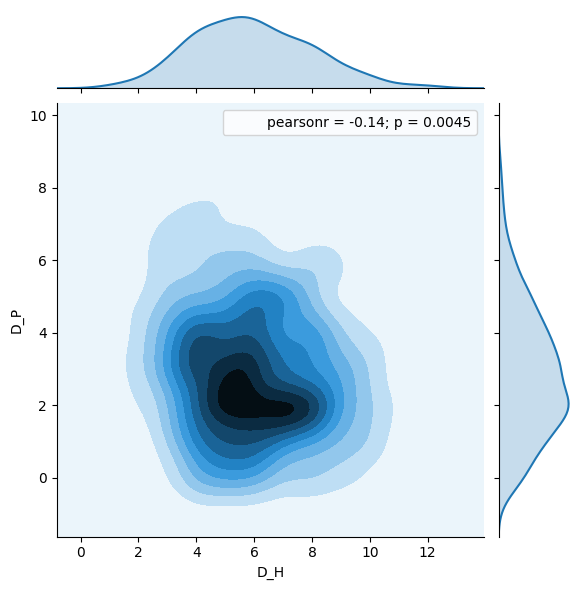

In [221]:
b = data2.query("Res1=='GLU' and Res2=='ALA'").reset_index(drop=True)
b["D_H"] = b["Density_H_x"] + b["Density_H_y"]
b["D_P"] = b["Density_P_x"] + b["Density_P_y"]
sns.jointplot("D_H", "D_P", data=b, kind="kde")

In [ ]:
a = data2.query("Res1=='LEU' and Res2=='LEU'").reset_index(drop=True)
a["D_H"] = a["Density_H_x"] + a["Density_H_y"]
a["D_P"] = a["Density_P_x"] + a["Density_P_y"]

In [154]:
a.sort_values("D_P")

,Res1,Res2,Type,Theta,Index1,Index2,r,index_x,Density_H_x,Density_P_x,index_y,Density_H_y,Density_P_y,Protein,D_H,D_P
135,LEU,LEU,Direct,1.000,6,63,5.423016,6,5.211,1.000,63,3.988,1.000,1cpq,9.199,2.000
175,LEU,LEU,Direct,1.000,36,88,4.225886,36,3.000,2.000,88,1.698,1.000,2sns,4.698,3.000
79,LEU,LEU,Direct,1.000,2,70,4.998909,2,3.856,2.049,70,1.023,1.000,1a6f,4.879,3.049
154,LEU,LEU,Direct,0.114,90,127,6.704611,90,3.000,2.121,127,1.305,1.108,1kuh,4.305,3.229
70,LEU,LEU,Direct,0.935,82,102,6.232599,82,1.000,2.935,102,2.125,0.935,1a1x,3.125,3.870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,LEU,LEU,Direct,1.000,32,71,5.142135,32,0.009,7.098,71,0.000,7.966,1rlw,0.009,15.064
168,LEU,LEU,Direct,1.000,49,64,5.588858,49,0.004,6.959,64,0.999,8.189,1pne,1.003,15.148
172,LEU,LEU,Direct,0.990,64,86,6.044071,64,0.999,8.189,86,0.008,6.990,1pne,1.007,15.179
165,LEU,LEU,Direct,1.000,49,108,5.543379,49,0.004,6.959,108,0.039,8.954,1pne,0.043,15.913


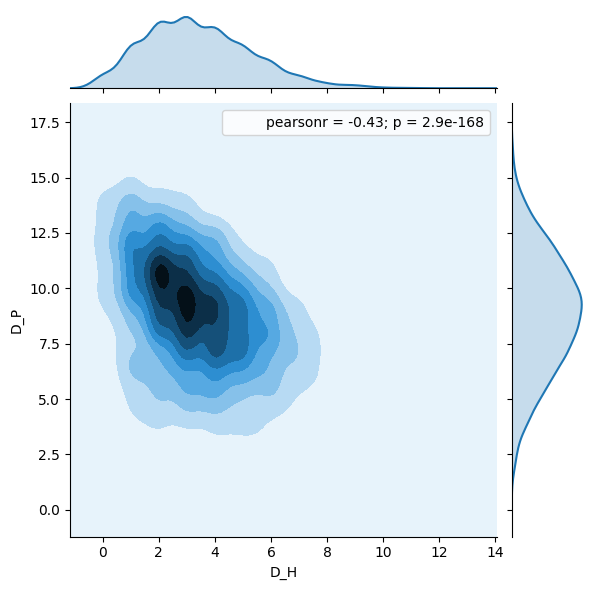

In [214]:
sns.jointplot("D_H", "D_P", data=a, kind="kde")

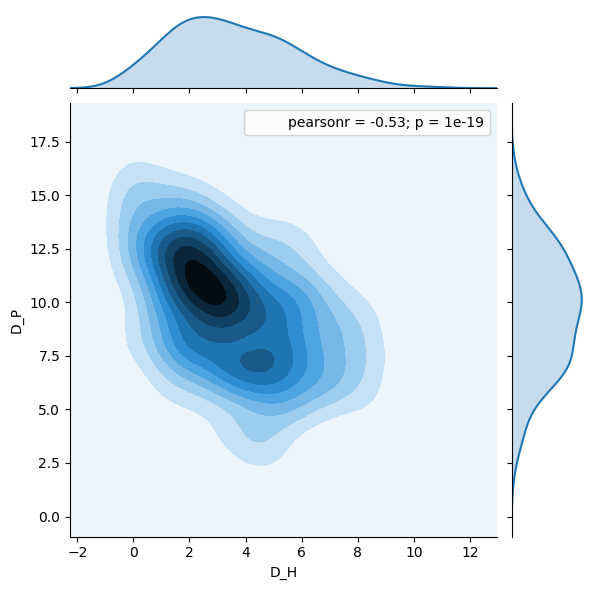

In [151]:
sns.jointplot("D_H", "D_P", data=a, kind="kde")

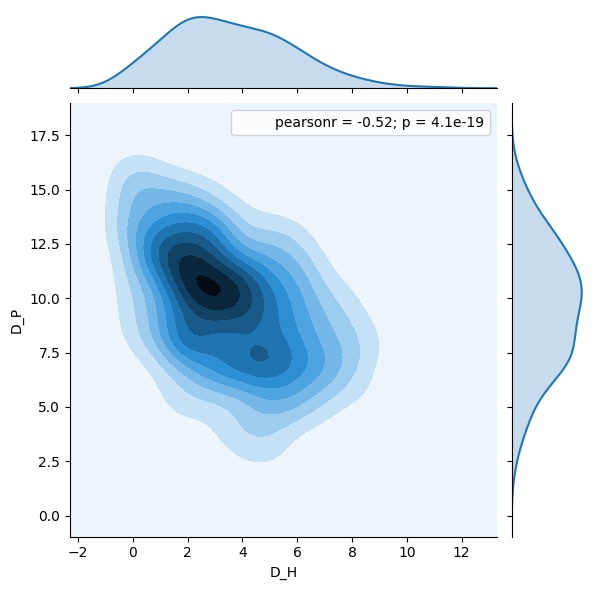

In [140]:
sns.jointplot("D_H", "D_P", data=a, kind="kde")

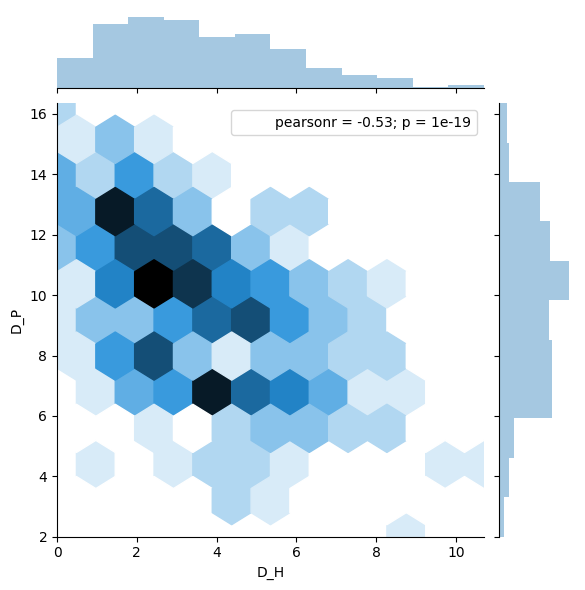

In [152]:
sns.jointplot("D_H", "D_P", data=a, kind="hex")

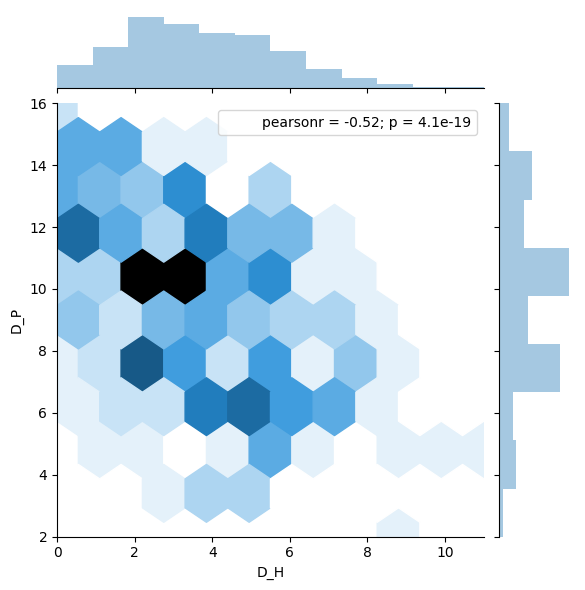

In [139]:
sns.jointplot("D_H", "D_P", data=a, kind="hex")

In [109]:
data_with_info = data.merge(data_envr, left_on="Index1", right_on="index").merge(data_envr, left_on="Index2", right_on="index")
data_with_info.query("Theta > 1e-1 and Type == 'Direct'").reset_index(drop=True)

,Res1,Res2,Type,Theta,Index1,Index2,r,index_x,Density_H_x,Density_P_x,index_y,Density_H_y,Density_P_y
0,ALA,SER,Direct,0.985,68,78,6.081271,68,3.233,2.011,78,3.792,1.000
1,ARG,TYR,Direct,1.000,27,67,5.312370,27,1.678,2.179,67,4.000,0.000
2,THR,TYR,Direct,1.000,29,67,5.425073,29,2.678,2.000,67,4.000,0.000
3,LEU,ILE,Direct,0.915,2,64,6.262689,2,1.001,5.733,64,0.000,4.962
4,LEU,ILE,Direct,0.949,12,64,6.207278,12,1.001,5.948,64,0.000,4.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,VAL,THR,Direct,0.587,23,70,6.464955,23,4.024,1.060,70,3.616,1.587
103,ARG,GLY,Direct,1.000,24,71,4.846040,24,1.041,0.000,71,1.996,0.001
104,ARG,GLU,Direct,1.000,27,41,4.193047,27,1.678,2.179,41,2.003,0.000
105,THR,GLU,Direct,1.000,29,41,5.378955,29,2.678,2.000,41,2.003,0.000


In [111]:
data_with_info.shape

(2349, 13)

In [39]:
isH = {}
isP = {}
for i in range(20):
    isH[dindex_to_1[i]] = res_type_map_HP[dindex_to_1[i]]
    isP[dindex_to_1[i]] = 1 - res_type_map_HP[dindex_to_1[i]]

In [75]:
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
sequence = get_sequence_from_structure(structure)
density_H = calculate_property_density(res_list, neighbor_list, isH).round()
density_P = calculate_property_density(res_list, neighbor_list, isP).round()



In [76]:
environment_info = pd.DataFrame([density_H, density_P], index=["Density_H", "Density_P"]).T.reset_index()

In [77]:
data_with_info = data.merge(environment_info, left_on="Index1", right_on="index").merge(environment_info, left_on="Index2", right_on="index")

In [80]:
a = data_with_info.query("Type=='Direct' and Theta > 1e-1")

In [87]:
a.groupby(["Res1", "Res2"])["Theta"].count().reset_index().sort_values("Theta")

,Res1,Res2,Theta
0,ALA,GLU,1
31,PHE,ILE,1
32,PRO,ALA,1
33,PRO,GLU,1
34,PRO,ILE,1
...,...,...,...
1,ALA,SER,3
68,VAL,ILE,3
27,LEU,THR,3
22,ILE,ILE,6


In [112]:
a.shape

(107, 13)

In [88]:
a.query("Res1 =='LEU' and Res2 == 'ILE'")

,Res1,Res2,Type,Theta,Index1,Index2,r,index_x,Density_H_x,Density_P_x,index_y,Density_H_y,Density_P_y
131,LEU,ILE,Direct,1.000,2,84,4.197815,2,1.0,6.0,84,0.0,2.0
791,LEU,ILE,Direct,1.000,2,14,5.333030,2,1.0,6.0,14,1.0,7.0
929,LEU,ILE,Direct,0.915,2,64,6.262689,2,1.0,6.0,64,0.0,5.0
938,LEU,ILE,Direct,0.949,12,64,6.207278,12,1.0,6.0,64,0.0,5.0
1142,LEU,ILE,Direct,1.000,2,82,5.090292,2,1.0,6.0,82,2.0,2.0
1535,LEU,ILE,Direct,1.000,12,53,4.717994,12,1.0,6.0,53,0.0,7.0


In [70]:
data.merge(environment_info, left_on="Index2", right_on="index")

,Res1,Res2,Type,Theta,Index1,Index2,r,index_x,Density_H_x,Density_P_x,index_y,Density_H_y,Density_P_y
0,ARG,VAL,Protein,0.0,0,69,13.319039,0,1.892,3.972,69,2.902,1.0
1,ARG,VAL,Water,0.0,0,69,13.319039,0,1.892,3.972,69,2.902,1.0
2,ARG,VAL,Direct,0.0,0,69,13.319039,0,1.892,3.972,69,2.902,1.0
3,TRP,VAL,Protein,0.0,16,69,12.675022,16,2.649,4.679,69,2.902,1.0
4,TRP,VAL,Water,0.0,16,69,12.675022,16,2.649,4.679,69,2.902,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344,ILE,VAL,Water,0.0,28,39,10.884260,28,1.000,5.199,39,2.000,0.0
2345,ILE,VAL,Direct,0.0,28,39,10.884260,28,1.000,5.199,39,2.000,0.0
2346,THR,VAL,Protein,0.0,29,39,4.840663,29,2.678,2.000,39,2.000,0.0
2347,THR,VAL,Water,0.0,29,39,4.840663,29,2.678,2.000,39,2.000,0.0


In [71]:
data

,Res1,Res2,Type,Theta,Index1,Index2,r,index,Density_H,Density_P
0,ARG,VAL,Protein,0.0,0,69,13.319039,0,1.892,3.972
1,ARG,VAL,Water,0.0,0,69,13.319039,0,1.892,3.972
2,ARG,VAL,Direct,0.0,0,69,13.319039,0,1.892,3.972
3,ARG,TYR,Protein,0.0,0,67,10.726437,0,1.892,3.972
4,ARG,TYR,Water,0.0,0,67,10.726437,0,1.892,3.972
...,...,...,...,...,...,...,...,...,...,...
2344,VAL,SER,Water,0.0,69,79,8.581514,69,2.902,1.000
2345,VAL,SER,Direct,0.0,69,79,8.581514,69,2.902,1.000
2346,THR,LYS,Protein,0.0,70,80,13.351789,70,3.616,1.587
2347,THR,LYS,Water,0.0,70,80,13.351789,70,3.616,1.587


In [66]:
environment_info

,index,Density_H,Density_P
0,0,1.892,3.972
1,1,1.443,0.000
2,2,1.001,5.733
3,3,1.443,1.000
4,4,1.000,3.294
...,...,...,...
86,86,1.959,2.000
87,87,1.000,0.686
88,88,2.552,3.960
89,89,2.956,0.000


In [57]:
density_H

array([1.892, 1.443, 1.001, 1.443, 1.   , 2.001, 0.   , 1.021, 2.956,
       2.553, 2.954, 2.992, 1.001, 3.002, 1.   , 3.   , 2.649, 2.   ,
       1.001, 2.891, 0.   , 3.988, 0.893, 4.024, 1.041, 1.278, 3.994,
       1.678, 1.   , 2.678, 1.   , 0.993, 2.983, 3.003, 0.   , 1.995,
       0.   , 1.978, 0.029, 2.   , 0.035, 2.003, 1.   , 0.012, 1.034,
       2.009, 0.038, 1.   , 1.162, 2.   , 1.162, 0.   , 1.855, 0.436,
       1.884, 0.955, 1.203, 1.   , 2.998, 2.   , 3.004, 2.12 , 3.044,
       4.01 , 0.   , 3.009, 1.001, 4.   , 3.233, 2.902, 3.616, 1.996,
       1.889, 3.493, 1.001, 1.173, 0.   , 1.552, 3.792, 2.4  , 0.   ,
       1.263, 1.779, 2.159, 0.   , 3.   , 1.959, 1.   , 2.552, 2.956,
       2.007])

In [50]:
density_P.round(1)

array([4., 0., 6., 1., 3., 1., 1., 3., 0., 0., 0., 0., 6., 1., 7., 1., 5.,
       0., 1., 3., 0., 0., 0., 1., 0., 1., 4., 2., 5., 2., 3., 2., 2., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 4., 1., 4., 0., 2., 0., 0., 1., 1.,
       5., 1., 7., 0., 0., 4., 1., 0., 1., 1., 0., 2., 0., 5., 1., 5., 0.,
       2., 1., 2., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 2., 0., 2.,
       0., 2., 1., 4., 0., 0.])

In [51]:
cb_density.round(1)

array([6., 1., 7., 2., 4., 3., 1., 4., 3., 3., 3., 3., 7., 4., 8., 4., 7.,
       2., 2., 6., 0., 4., 1., 5., 1., 2., 8., 4., 6., 5., 4., 3., 5., 3.,
       0., 2., 0., 2., 0., 2., 1., 2., 5., 1., 5., 2., 2., 1., 1., 3., 2.,
       5., 3., 7., 2., 1., 5., 2., 3., 3., 4., 2., 5., 4., 5., 4., 6., 4.,
       5., 4., 5., 2., 3., 3., 2., 1., 0., 2., 5., 3., 1., 2., 4., 2., 2.,
       3., 4., 2., 7., 3., 2.])

In [31]:
# get environmental information
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
sequence = get_sequence_from_structure(structure)
cb_density = calculate_cb_density(res_list, neighbor_list)
r_min_direct = 2.5
r_max_direct = 6.5
r_min = 6.5
r_max = 9.5
kappa = 5.0
min_seq_sep = 10
density_threshold = 2.6
density_kappa = 7.0
# phi_mediated_contact_well = np.zeros((2, 20,20))
v_mediated = 0
data_ = []
for res1globalindex, res1 in enumerate(res_list):
    res1index = get_local_index(res1)
    res1chain = get_chain(res1)
    rho_i = cb_density[res1globalindex]
    for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
        res2index = get_local_index(res2)
        res2chain = get_chain(res2)
        res2globalindex = get_global_index(res_list, res2)
        rho_j = cb_density[res2globalindex]

        if res2globalindex - res1globalindex >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
            res1type = get_res_type(res_list, res1)
            res2type = get_res_type(res_list, res2)
            rij = get_interaction_distance(res1, res2)
            theta = interaction_well(rij, r_min, r_max, kappa)
            water_theta = prot_water_switchFunc_sigmaWater(rho_i, rho_j, density_threshold, density_kappa) * theta
            protein_theta = prot_water_switchFunc_sigmaProt(rho_i, rho_j, density_threshold, density_kappa) * theta
            data_.append([res1.resname, res2.resname, "Protein", round(protein_theta, 3), res1globalindex, res2globalindex, rij])
            data_.append([res1.resname, res2.resname, "Water", round(water_theta, 3), res1globalindex, res2globalindex, rij])
            direct_theta = interaction_well(rij, r_min_direct, r_max_direct, kappa)
            data_.append([res1.resname, res2.resname, "Direct", round(direct_theta, 3), res1globalindex, res2globalindex, rij])
            # protein_gamma = protein_gamma_ijm[0][res1type][res2type]*k_hypercharge
            # water_gamma = water_gamma_ijm[0][res1type][res2type]*k_hypercharge
data = pd.DataFrame(data_, columns=["Res1", "Res2", "Type", "Theta", "Index1", "Index2", "r"])



In [47]:
structure = s
kappa=5.0
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
sequence = get_sequence_from_structure(structure)
cb_density = calculate_cb_density(res_list, neighbor_list)
r_min_direct = 2.5
r_max_direct = 6.5
r_min = 6.5
r_max = 9.5
# kappa = 5.0
min_seq_sep = 10
density_threshold = 2.6
density_kappa = 7.0
# phi_mediated_contact_well = np.zeros((2, 20,20))
v_mediated = 0
data_ = []
for res1globalindex, res1 in enumerate(res_list):
    res1index = get_local_index(res1)
    res1chain = get_chain(res1)
    rho_i = cb_density[res1globalindex]
    for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
        res2index = get_local_index(res2)
        res2chain = get_chain(res2)
        res2globalindex = get_global_index(res_list, res2)
        rho_j = cb_density[res2globalindex]

        if res2globalindex - res1globalindex >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
            res1type = get_res_type(res_list, res1)
            res2type = get_res_type(res_list, res2)
            rij = get_interaction_distance(res1, res2)
            theta = interaction_well(rij, r_min, r_max, kappa)
            water_theta = prot_water_switchFunc_sigmaWater(rho_i, rho_j, density_threshold, density_kappa) * theta
            protein_theta = prot_water_switchFunc_sigmaProt(rho_i, rho_j, density_threshold, density_kappa) * theta
            data_.append([res1.resname, res2.resname, "Protein", round(protein_theta, 3), res1globalindex, res2globalindex])
            data_.append([res1.resname, res2.resname, "Water", round(water_theta, 3), res1globalindex, res2globalindex])
            direct_theta = interaction_well(rij, r_min_direct, r_max_direct, kappa)
            data_.append([res1.resname, res2.resname, "Direct", round(direct_theta, 3), res1globalindex, res2globalindex])
            # protein_gamma = protein_gamma_ijm[0][res1type][res2type]*k_hypercharge
            # water_gamma = water_gamma_ijm[0][res1type][res2type]*k_hypercharge
data = pd.DataFrame(data_, columns=["Res1", "Res2", "Type", "Theta", "Index1", "Index2"])

In [30]:
gammaFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_optimization/optimization_larger_excl_withoutBurial/iter_larger_excl_withoutBurial_30"
contact_gammas = get_contact_gamma_info(gammaFile)

contact_gammas["Res1"] = contact_gammas.apply(lambda x: one_to_three(x["Res1"]), axis=1)
contact_gammas["Res2"] = contact_gammas.apply(lambda x: one_to_three(x["Res2"]), axis=1)
contact_gammas["Type"] = contact_gammas["Interaction"]

# pdb = "1sfp"
# pdb = "1who"
pdb = "1jon"
pdb = "1neu"
pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/iteration_1_stronger_exclude_withoutBurial/{pdb}/0/lastFrame.pdb"
parser = PDBParser()
structure = parser.get_structure("X", pdbFile)
data = get_interaction_data(structure)

a = data.merge(contact_gammas, on=["Res1", "Res2", "Type"])
a["theta_gamma"] = a["Theta"] * a["Gamma"]

pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/iteration_1_stronger_exclude_withoutBurial/{pdb}/0/crystal_structure.pdb"
parser = PDBParser()
structure = parser.get_structure("X", pdbFile)
data_native = get_interaction_data(structure)

a_native = data_native.merge(contact_gammas, on=["Res1", "Res2", "Type"])
a_native["theta_gamma"] = a_native["Theta"] * a_native["Gamma"]

In [31]:
a[["Type", "theta_gamma"]].groupby("Type").sum()

,theta_gamma
Type,
Direct,-101.276373
Protein,-105.200971
Water,-1.311072


In [32]:
a_native[["Type", "theta_gamma"]].groupby("Type").sum()

,theta_gamma
Type,
Direct,-59.127062
Protein,-66.563254
Water,-4.710177


In [33]:
a[["Type", "theta_gamma"]].groupby("Type").sum().sum()

theta_gamma   -207.788416
dtype: float64

In [34]:
b2 = a.query("Theta > 0.1").groupby(["Res1", "Res2", "Type"])["theta_gamma"].count().reset_index()
b2.sort_values("theta_gamma").tail(5)

,Res1,Res2,Type,theta_gamma
276,SER,VAL,Protein,7
264,SER,LYS,Protein,7
140,GLY,VAL,Protein,7
165,ILE,ILE,Direct,7
364,VAL,SER,Protein,8


In [35]:
b3 = a.query("Theta > 0.1").groupby(["Res1", "Res2", "Type"])["theta_gamma"].sum().reset_index()
b3.sort_values("theta_gamma").head(5)

,Res1,Res2,Type,theta_gamma
165,ILE,ILE,Direct,-5.859840
54,ASP,LYS,Direct,-4.141928
181,ILE,VAL,Direct,-3.560194
171,ILE,PHE,Direct,-3.555981
29,ARG,PHE,Protein,-2.875323


In [36]:
b2_native = a_native.query("Theta > 0.1").groupby(["Res1", "Res2", "Type"])["theta_gamma"].count().reset_index()
b2_native.sort_values("theta_gamma").tail(5)

,Res1,Res2,Type,theta_gamma
299,VAL,SER,Protein,5
142,ILE,PHE,Protein,5
137,ILE,ILE,Protein,5
307,VAL,VAL,Protein,5
172,PHE,ASP,Protein,6


In [37]:
b3_native = a_native.query("Theta > 0.1").groupby(["Res1", "Res2", "Type"])["theta_gamma"].sum().reset_index()
b3_native.sort_values("theta_gamma").head(5)

,Res1,Res2,Type,theta_gamma
250,TRP,ILE,Direct,-4.199720
306,VAL,VAL,Direct,-3.221582
180,PHE,ILE,Direct,-2.645379
136,ILE,ILE,Direct,-2.453640
292,VAL,LEU,Direct,-2.448768


In [60]:
gammaFile = "/Users/weilu/Research/server/mar_2020/cath_dataset_shuffle_optimization/optimization_iter0_com_density_rmin_2p5/saved_gammas/iter0_cutoff600_impose_Aprime_constraint"
contact_gammas = get_contact_gamma_info(gammaFile)

contact_gammas["Res1"] = contact_gammas.apply(lambda x: one_to_three(x["Res1"]), axis=1)
contact_gammas["Res2"] = contact_gammas.apply(lambda x: one_to_three(x["Res2"]), axis=1)
contact_gammas["Type"] = contact_gammas["Interaction"]

pdb = "1sfp"
pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/iteration_0_stronger_exclude_volume/{pdb}/0/lastFrame.pdb"
parser = PDBParser()
structure = parser.get_structure("X", pdbFile)
data = get_interaction_data(structure)

a = data.merge(contact_gammas, on=["Res1", "Res2", "Type"])
a["theta_gamma"] = a["Theta"] * a["Gamma"]


In [61]:
a[["Type", "theta_gamma"]].groupby("Type").sum()

,theta_gamma
Type,
Direct,-71.788934
Protein,-11.780707
Water,-2.330682


In [62]:
b2 = a.query("Theta > 0.1").groupby(["Res1", "Res2", "Type"])["theta_gamma"].count().reset_index()
b2.sort_values("theta_gamma").tail(5)

,Res1,Res2,Type,theta_gamma
111,GLY,TYR,Protein,5
134,ILE,LEU,Protein,6
132,ILE,ILE,Protein,6
130,ILE,GLY,Protein,6
146,ILE,VAL,Protein,6


In [20]:
b3 = a.query("Theta > 0.1").groupby(["Res1", "Res2", "Type"])["theta_gamma"].sum().reset_index()
b3.sort_values("theta_gamma").head(5)

,Res1,Res2,Type,theta_gamma
19,CYS,CYS,Direct,-25.324650
149,VAL,LEU,Direct,-11.089641
20,CYS,CYS,Protein,-6.585576
26,CYS,LEU,Protein,-3.843926
104,PHE,CYS,Direct,-3.533796


In [25]:
fastaFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_run/iteration_0_stronger_exclude_volume/3cyr/0/crystal_structure.fasta"
seq = read_fasta(fastaFile)

In [26]:
seq.count("C")

8

In [27]:
data = pd.read_csv("/Users/weilu/Research/server/mar_2020/mass_iterative_run/training_set.csv")
specific_decoys = data.query("Length < 150 and Length > 70").reset_index(drop=True)
pdb_list = specific_decoys["Protein"].to_list()
pdb_list = [a.lower() for a in pdb_list]
skip_pdb_list = ["1puc", "1skz"]
skip_pdb_list += ["1msc", "1fmb", "1gvp", "2tgi", "1whi", "1baj", "1rmd", "1div"]  #dimer.
skip_pdb_list += ["1aqe"]  # lots of ligand
filtered_pdb_list = [x for x in pdb_list if x not in skip_pdb_list]
pdb_list = filtered_pdb_list

In [65]:
info_ = []
for pdb in pdb_list:
    seq = np.loadtxt(f"/Users/weilu/Research/server/mar_2020/mass_iterative_optimization/database/S20_seq/{pdb}.seq", dtype=str)
    seq = str(seq)
    info_.append([pdb, seq, seq.count("C"), len(seq)])

In [66]:
data = pd.DataFrame(info_, columns=["Protein", "Seq", "Count", "Length"])

In [67]:
data.to_csv("/Users/weilu/Research/server/mar_2020/mass_iterative_optimization/cys_count_data.csv")

In [47]:
data["Length"] = data["Seq"].apply(lambda x:len(x))

In [70]:
print(data.sort_values("Count").query("Count >= 6")["Protein"].to_list())

['1by2', '1rcb', '1hyp', '3lzt', '3cyr', '7rsa', '1rzl', '1b6e', '1poc', '1bea', '1poa']


In [64]:
data

,Res1,Res2,Type,Theta,Index1,Index2,r
0,LEU,ALA,Protein,0.000,0,18,11.045428
1,LEU,ALA,Water,0.000,0,18,11.045428
2,LEU,ALA,Direct,0.000,0,18,11.045428
3,LEU,ARG,Protein,0.033,0,40,9.838098
4,LEU,ARG,Water,0.000,0,40,9.838098
...,...,...,...,...,...,...,...
3097,TYR,GLU,Water,0.000,89,101,15.198022
3098,TYR,GLU,Direct,0.000,89,101,15.198022
3099,ILE,TYR,Protein,0.000,90,100,10.454025
3100,ILE,TYR,Water,0.000,90,100,10.454025


In [20]:
gammaFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_optimization/optimization_new_4_withoutBurial/saved_gammas/new_4_cutoff600_impose_Aprime_constraint"
contact_gammas = get_contact_gamma_info(gammaFile)

In [75]:
# contact_gammas["Res1"] = contact_gammas.apply(lambda x: one_to_three(x["Res1"]), axis=1)
# contact_gammas["Res2"] = contact_gammas.apply(lambda x: one_to_three(x["Res2"]), axis=1)
contact_gammas["Type"] = contact_gammas["Interaction"]
a = data.merge(contact_gammas, on=["Res1", "Res2", "Type"])
a["theta_gamma"] = a["Theta"] * a["Gamma"]

In [77]:
a["theta_gamma"] = a["Theta"] * a["Gamma"]

In [78]:
a[["Type", "theta_gamma"]].groupby("Type").sum()

,theta_gamma
Type,
Direct,-949.732540
Protein,-479.435681
Water,-8.402658


In [79]:
a["theta_gamma"].sum()

-1437.5708789999999

In [80]:
b2 = a.query("Theta > 0.1").groupby(["Res1", "Res2", "Type"])["theta_gamma"].count().reset_index()

In [83]:
b3 = a.query("Theta > 0.1").groupby(["Res1", "Res2", "Type"])["theta_gamma"].sum().reset_index()

In [91]:
b3.sort_values("theta_gamma").head(200)["theta_gamma"].sum()

-1483.202181

In [96]:
a.query("Res1 == 'TYR' and Res2 == 'CYS' and Theta > 0.1 and Type =='Direct'").sort_values("r")

,Res1,Res2,Type,Theta,Index1,Index2,r,Interaction,Index,Gamma,theta_gamma
890,TYR,CYS,Direct,0.956,23,77,2.808838,Direct,88,-4.012,-3.835472
921,TYR,CYS,Direct,0.999,66,84,3.204737,Direct,88,-4.012,-4.007988
876,TYR,CYS,Direct,1.000,2,89,3.921630,Direct,88,-4.012,-4.012000
877,TYR,CYS,Direct,1.000,2,84,3.969086,Direct,88,-4.012,-4.012000
926,TYR,CYS,Direct,1.000,68,91,4.097748,Direct,88,-4.012,-4.012000
897,TYR,CYS,Direct,1.000,26,91,4.154008,Direct,88,-4.012,-4.012000
912,TYR,CYS,Direct,1.000,62,117,4.176590,Direct,88,-4.012,-4.012000
898,TYR,CYS,Direct,1.000,26,70,4.354343,Direct,88,-4.012,-4.012000
906,TYR,CYS,Direct,1.000,50,84,4.464048,Direct,88,-4.012,-4.012000
905,TYR,CYS,Direct,1.000,50,117,4.704973,Direct,88,-4.012,-4.012000


In [86]:
b3.sort_values("theta_gamma").head(20)

,Res1,Res2,Type,theta_gamma
342,TYR,CYS,Direct,-130.883476
321,TRP,CYS,Direct,-106.422800
113,CYS,TYR,Protein,-90.723716
343,TYR,CYS,Protein,-87.706208
112,CYS,TYR,Direct,-73.202952
320,TRP,ASN,Protein,-58.802645
226,MET,CYS,Direct,-50.142196
246,PHE,CYS,Direct,-32.165329
279,SER,CYS,Direct,-30.213630
188,ILE,TYR,Direct,-28.798753


In [69]:
b2.sort_values("theta_gamma").tail(10)

,Res1,Res2,Type,theta_gamma
87,CYS,ALA,Protein,18
112,CYS,TYR,Direct,19
320,TRP,ASN,Protein,19
336,TYR,ALA,Protein,20
357,TYR,TYR,Direct,22
343,TYR,CYS,Protein,28
113,CYS,TYR,Protein,29
321,TRP,CYS,Direct,30
342,TYR,CYS,Direct,34
94,CYS,CYS,Protein,45


In [82]:
a.query("Res1 == 'CYS' and Res2 == 'CYS' and Theta > 0.1")

,Res1,Res2,Type,Theta,Index1,Index2,r,Interaction,Index,Gamma,theta_gamma
3153,CYS,CYS,Protein,1.000,10,25,7.411365,Protein,284,-0.477,-0.477000
3154,CYS,CYS,Protein,0.987,10,59,9.068994,Protein,284,-0.477,-0.470799
3155,CYS,CYS,Protein,1.000,10,27,7.557992,Protein,284,-0.477,-0.477000
3157,CYS,CYS,Protein,1.000,10,84,8.094460,Protein,284,-0.477,-0.477000
3158,CYS,CYS,Protein,0.938,10,77,6.771117,Protein,284,-0.477,-0.447426
3159,CYS,CYS,Protein,0.998,10,43,7.104249,Protein,284,-0.477,-0.476046
3160,CYS,CYS,Protein,0.999,10,42,8.782217,Protein,284,-0.477,-0.476523
3161,CYS,CYS,Protein,0.678,10,91,9.425323,Protein,284,-0.477,-0.323406
3162,CYS,CYS,Protein,0.288,25,59,9.590501,Protein,284,-0.477,-0.137376
3163,CYS,CYS,Protein,0.976,25,98,9.128296,Protein,284,-0.477,-0.465552


In [56]:
a.sort_values("theta_gamma")

,Res1,Res2,Type,Theta,Index1,Index2,Interaction,Index,Gamma,theta_gamma
1904,GLN,HIS,Direct,1.000,9,46,Direct,93,-4.963,-4.963000
2490,MET,CYS,Direct,1.000,7,84,Direct,82,-4.654,-4.654000
2501,MET,CYS,Direct,1.000,7,43,Direct,82,-4.654,-4.654000
2499,MET,CYS,Direct,1.000,7,25,Direct,82,-4.654,-4.654000
2491,MET,CYS,Direct,0.999,7,42,Direct,82,-4.654,-4.649346
...,...,...,...,...,...,...,...,...,...,...
149,ASN,ASN,Direct,0.960,0,112,Direct,39,1.119,1.074240
5023,SER,THR,Direct,1.000,32,74,Direct,196,1.075,1.075000
6450,ASP,TRP,Protein,0.998,19,60,Protein,281,1.097,1.094806
3316,CYS,CYS,Direct,1.000,25,89,Direct,74,2.484,2.484000


In [4]:
from Bio.PDB.Polypeptide import d1_to_index
from Bio.PDB.Polypeptide import dindex_to_1

pdb = "2a0b"

pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/cbd-openmmawsem.pdb"
seq = read_fasta(f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/crystal_structure.fasta")
def get_contact_info(pdbFile, seq, frame_index=0):
    # frame_index = 0
    cutoff = 9.5
    MAX_OFFSET = 9
    parser = PDBParser()
    structure = parser.get_structure("x", pdbFile)
    models = list(structure.get_models())
    model = models[frame_index]
    all_residues = list(model.get_residues())
    info_ = []
    for i, res1 in enumerate(all_residues):
        if seq[i] == "G":
            a1 = res1["CA"]
        else:
            a1 = res1["CB"]
        for j, res2 in enumerate(all_residues):
            if seq[j] == "G":
                a2 = res2["CA"]
            else:
                a2 = res2["CB"]
            dis = a1 - a2
            if dis < cutoff and j - i > MAX_OFFSET:
                info_.append([pdb, i, j, seq[i], seq[j], dis])
    info = pd.DataFrame(info_, columns=["Protein", "i", "j", "Resi", "Resj", "Dis"])
    return info

In [82]:
data = pd.read_csv("training_set.csv")
specific_decoys = data.query("Length < 150 and Length > 70").reset_index(drop=True)
pdb_list = specific_decoys["Protein"].to_list()
pdb_list = [a.lower() for a in pdb_list]
skip_pdb_list = ["1puc", "1skz"]
skip_pdb_list += ["1msc", "1fmb", "1gvp", "2tgi", "1whi", "1baj", "1rmd", "1div"]  #dimer.
skip_pdb_list += ["1aqe"]  # lots of ligand
filtered_pdb_list = [x for x in pdb_list if x not in skip_pdb_list]
pdb_list = filtered_pdb_list

In [9]:
info_ = []
for pdb in pdb_list:
    pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/cbd-openmmawsem.pdb"
    seq = read_fasta(f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/crystal_structure.fasta")
    info = get_contact_info(pdbFile, seq)
    info_.append(info)
info = pd.concat(info_)

In [14]:
direct_contact_table = np.zeros((20,20))
for i, line in info.iterrows():
    resi = line["Resi"]
    resj = line["Resj"]
    dis = line["Dis"]
    if dis < 6.5:
        direct_contact_table[d1_to_index[resi]][d1_to_index[resj]] += 1
        if resi != resj:
            direct_contact_table[d1_to_index[resj]][d1_to_index[resi]] += 1

In [16]:
direct_contact_table.min()

3.0

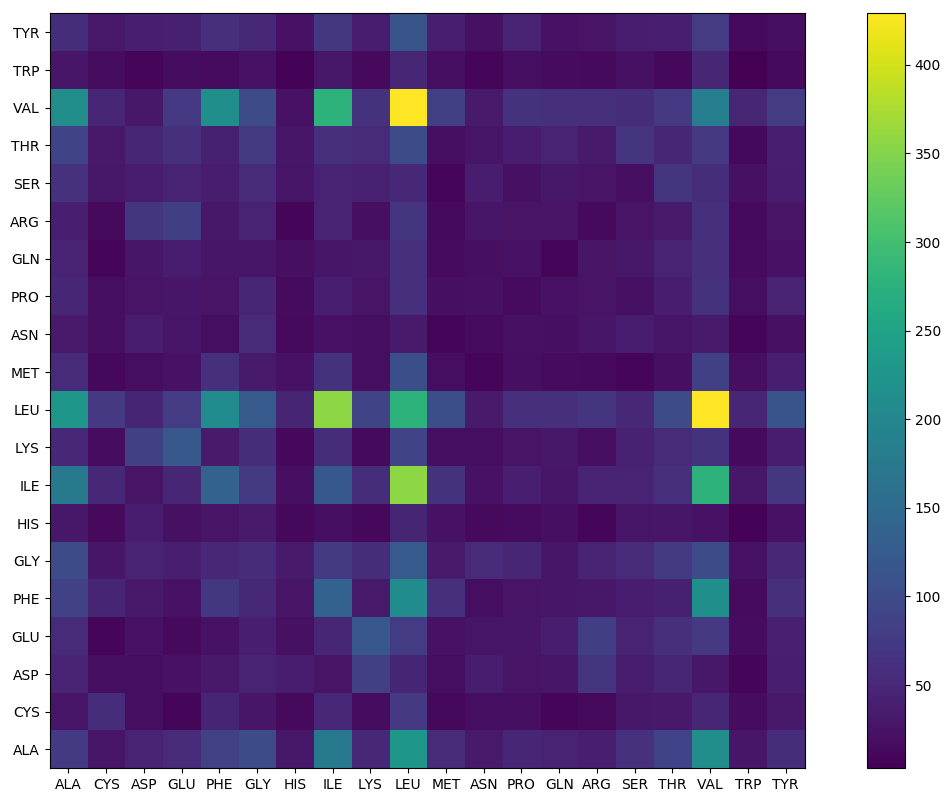

In [15]:
plt.imshow(direct_contact_table, origin=0)
plt.colorbar()
_ = plt.xticks(np.arange(20), aa3)
_ = plt.yticks(np.arange(20), aa3)

In [11]:
contact_table = np.zeros((20,20))
for i, line in info.iterrows():
    resi = line["Resi"]
    resj = line["Resj"]
    dis = line["Dis"]
    contact_table[d1_to_index[resi]][d1_to_index[resj]] += 1
    if resi != resj:
        contact_table[d1_to_index[resj]][d1_to_index[resi]] += 1

In [12]:
len(info)

32267

In [13]:
contact_table.min()

12.0

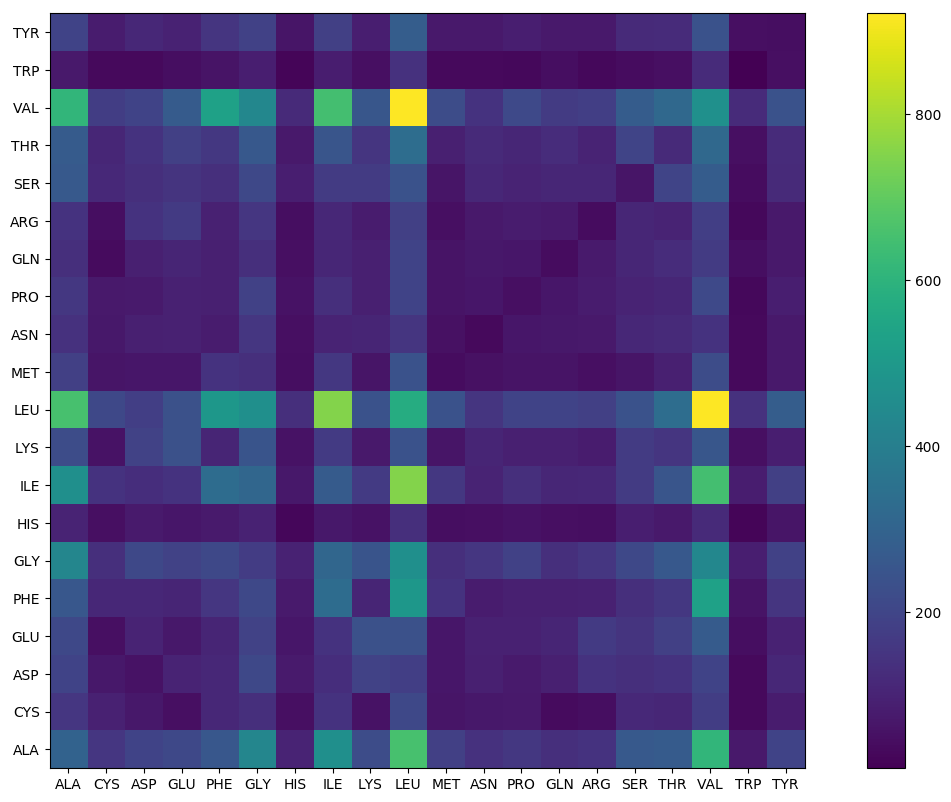

In [115]:
plt.imshow(contact_table, origin=0)
plt.colorbar()
_ = plt.xticks(np.arange(20), aa3)
_ = plt.yticks(np.arange(20), aa3)

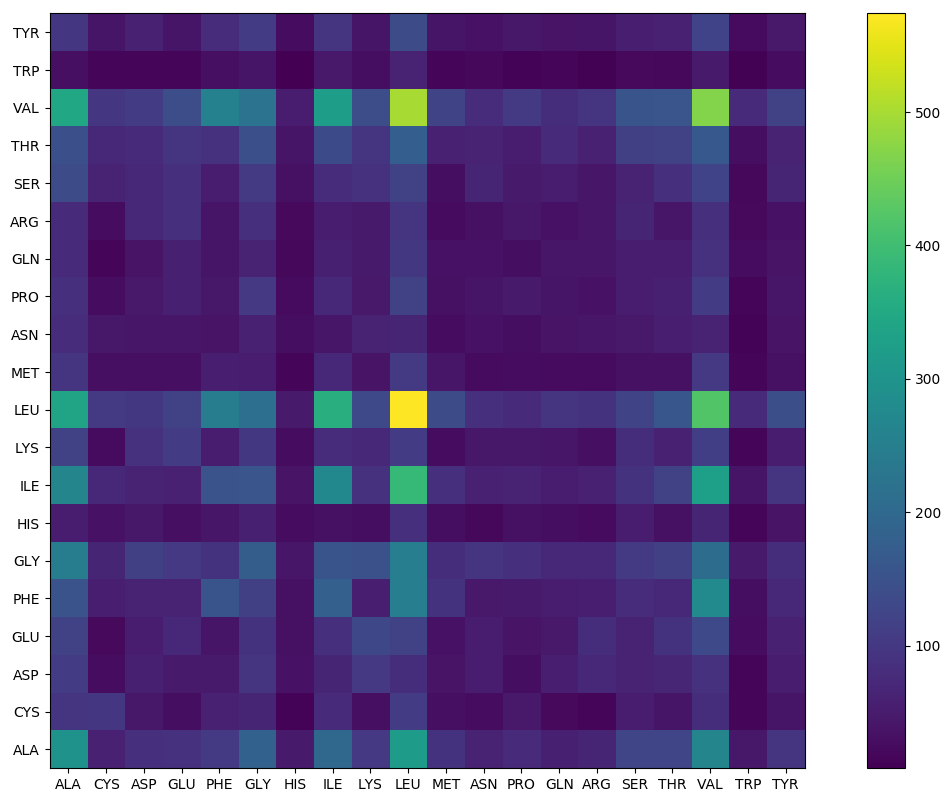

In [109]:
plt.imshow(contact_table, origin=0)
plt.colorbar()
_ = plt.xticks(np.arange(20), aa3)
_ = plt.yticks(np.arange(20), aa3)

In [88]:
info.groupby(["Resi", "Resj"])["Dis"].count()

Resi  Resj
A     A       297
      C        60
      D        87
      E        88
      F       105
             ... 
Y     S        55
      T        61
      V       122
      W        24
      Y        46
Name: Dis, Length: 400, dtype: int64

In [81]:

pdb = "2a0b"

pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/cbd-openmmawsem.pdb"
seq = read_fasta(f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/crystal_structure.fasta")
get_contact_info(pdbFile, seq)

,Protein,i,j,Resi,Resj,Dis
0,2a0b,1,104,K,H,5.800971
1,2a0b,1,105,K,D,8.981970
2,2a0b,1,108,K,V,4.504978
3,2a0b,1,111,K,A,8.126446
4,2a0b,2,108,S,V,5.637322
...,...,...,...,...,...,...
267,2a0b,79,94,I,W,6.115420
268,2a0b,79,95,I,I,5.385581
269,2a0b,79,98,I,M,4.980760
270,2a0b,81,94,S,W,8.732571


In [78]:
from Bio.PDB.Polypeptide import d1_to_index
from Bio.PDB.Polypeptide import dindex_to_1

pdb = "2a0b"

pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/cbd-openmmawsem.pdb"
seq = read_fasta(f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/crystal_structure.fasta")

frame_index = 0
cutoff = 9.5
MAX_OFFSET = 9
parser = PDBParser()
structure = parser.get_structure("x", pdbFile)
models = list(structure.get_models())
model = models[frame_index]
all_residues = list(model.get_residues())
info_ = []
for i, res1 in enumerate(all_residues):
    if seq[i] == "G":
        a1 = res1["CA"]
    else:
        a1 = res1["CB"]
    for j, res2 in enumerate(all_residues):
        if seq[j] == "G":
            a2 = res2["CA"]
        else:
            a2 = res2["CB"]
        dis = a1 - a2
        if dis < cutoff and j - i > MAX_OFFSET:
            info_.append([pdb, i, j, seq[i], seq[j], dis])


In [6]:
def getContactMapFromPDB(pdbFile, seq, frame_index=0):
    cutoff = 9.5
    MAX_OFFSET = 9
    parser = PDBParser()
    structure = parser.get_structure("x", pdbFile)
    models = list(structure.get_models())
    model = models[frame_index]
    all_residues = list(model.get_residues())
    n = len(all_residues)
    contact_table = np.zeros((n,n))
    # print(pdb, n)#
    for i, res1 in enumerate(all_residues):
        if seq[i] == "G":
            a1 = res1["CA"]
        else:
            a1 = res1["CB"]
        for j, res2 in enumerate(all_residues):
            if seq[j] == "G":
                a2 = res2["CA"]
            else:
                a2 = res2["CB"]
            contact_table[i][j] = a1 - a2

    data = (contact_table < cutoff)
    remove_band = np.eye(n)
    for i in range(1, MAX_OFFSET):
        remove_band += np.eye(n, k=i)
        remove_band += np.eye(n, k=-i)
    data[remove_band==1] = 0
    return data

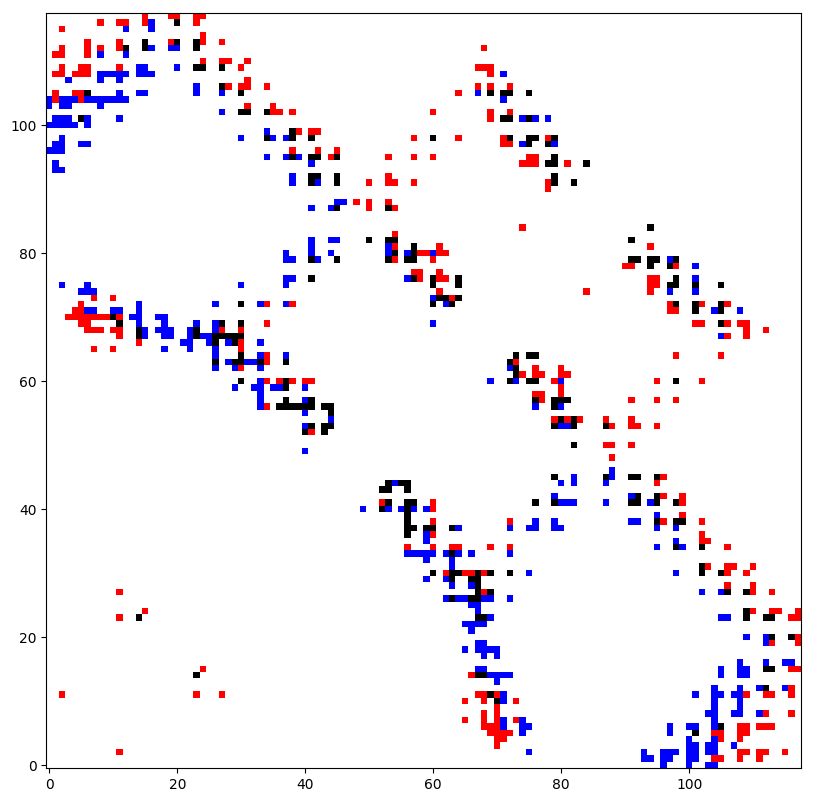

In [81]:
pdb = "2a0b"

pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/cbd-openmmawsem.pdb"
# pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/iteration_start_native_iter5/{pdb}/0/movie.pdb"
seq = read_fasta(f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/crystal_structure.fasta")
data_native = getContactMapFromPDB(pdbFile, seq, frame_index=-1)

pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/iteration_start_native_iter5/{pdb}/0/lastFrame.pdb"
# pdbFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_run/test/native.pdb"
data_predicted = getContactMapFromPDB(pdbFile, seq, frame_index=-1)

combined = data_native + data_predicted * 2
from matplotlib import colors
# white means not present in both
# red means present in the first but not the second
# blue means present in the second but not the first
# black means present in both
cmap = colors.ListedColormap(['white', 'red', 'blue', 'black'])
bounds=[-1,0.1, 1.1, 2.1, 3.1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.imshow(combined, origin="bottom", cmap=cmap, norm=norm)




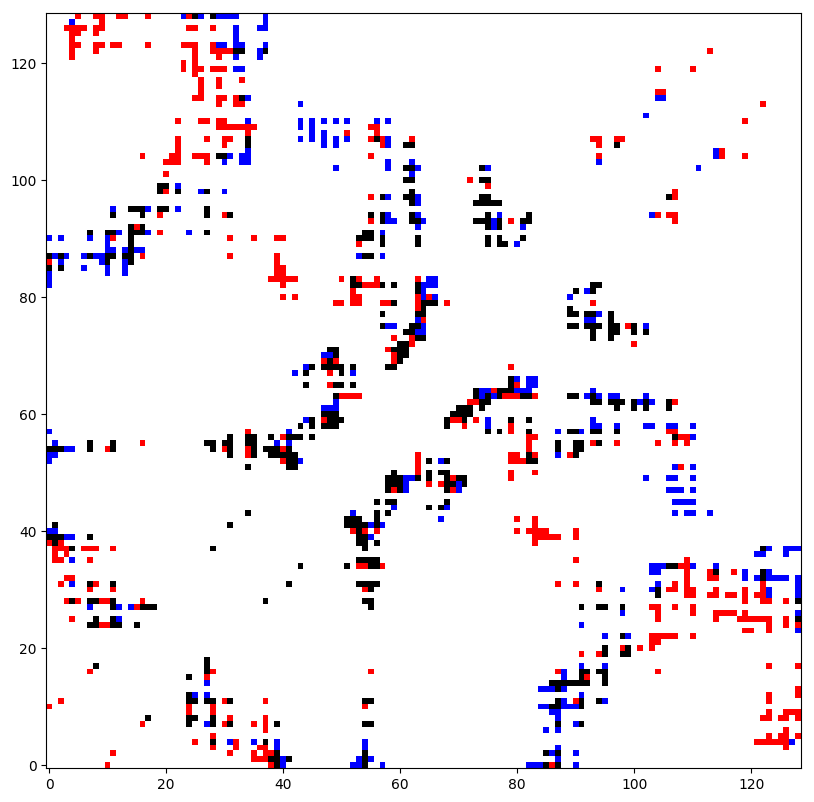

In [7]:
pdb = "3lzt"

pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/cbd-openmmawsem.pdb"
seq = read_fasta(f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/crystal_structure.fasta")
data_native = getContactMapFromPDB(pdbFile, seq)

pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/iteration_start_native_iter5/{pdb}/0/lastFrame.pdb"
# pdbFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_run/test/native.pdb"
data_predicted = getContactMapFromPDB(pdbFile, seq, frame_index=-1)

combined = data_native + data_predicted * 2
from matplotlib import colors
# white means not present in both
# red means present in the first but not the second
# blue means present in the second but not the first
# black means present in both
cmap = colors.ListedColormap(['white', 'red', 'blue', 'black'])
bounds=[-1,0.1, 1.1, 2.1, 3.1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.imshow(combined, origin="bottom", cmap=cmap, norm=norm)



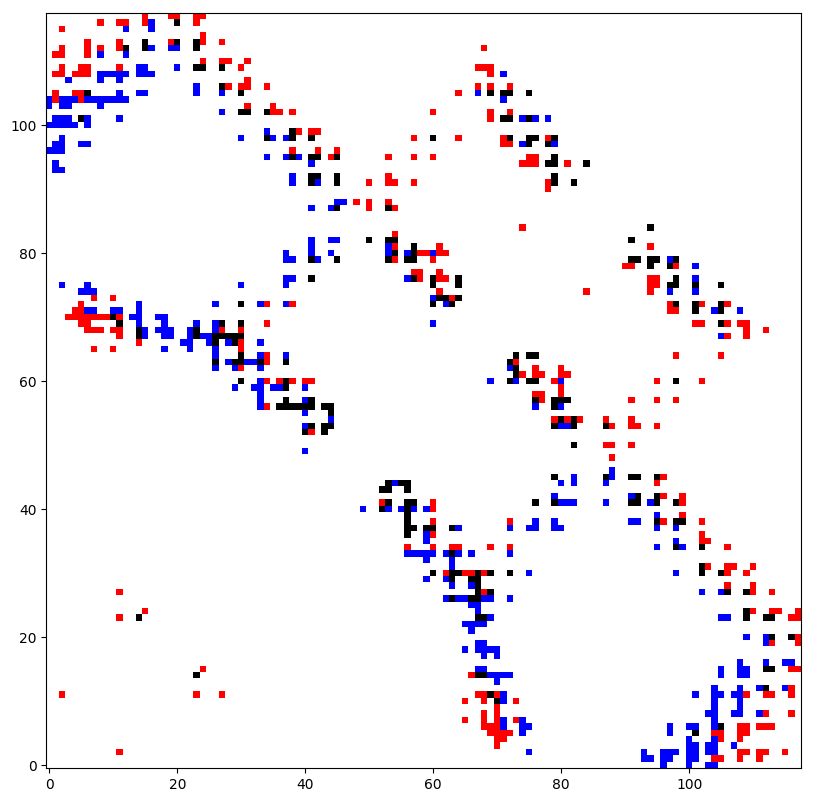

In [66]:
pdb = "2a0b"

pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/cbd-openmmawsem.pdb"
seq = read_fasta(f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/{pdb}/crystal_structure.fasta")
data_native = getContactMapFromPDB(pdbFile, seq)

pdbFile = f"/Users/weilu/Research/server/mar_2020/mass_iterative_run/iteration_start_native_iter5/{pdb}/0/lastFrame.pdb"
# pdbFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_run/test/native.pdb"
data_predicted = getContactMapFromPDB(pdbFile, seq, frame_index=-1)

combined = data_native + data_predicted * 2
from matplotlib import colors
# white means not present in both
# red means present in the first but not the second
# blue means present in the second but not the first
# black means present in both
cmap = colors.ListedColormap(['white', 'red', 'blue', 'black'])
bounds=[-1,0.1, 1.1, 2.1, 3.1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.imshow(combined, origin="bottom", cmap=cmap, norm=norm)


In [58]:
pdbFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/1baj/cbd-openmmawsem.pdb"
seq = read_fasta("/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/1baj/crystal_structure.fasta")
data_native = getContactMapFromPDB(pdbFile, seq)

In [63]:
pdbFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_run/iteration_start_native_iter5/1baj/0/lastFrame.pdb"
# pdbFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_run/test/native.pdb"
data_predicted = getContactMapFromPDB(pdbFile, seq, frame_index=-1)

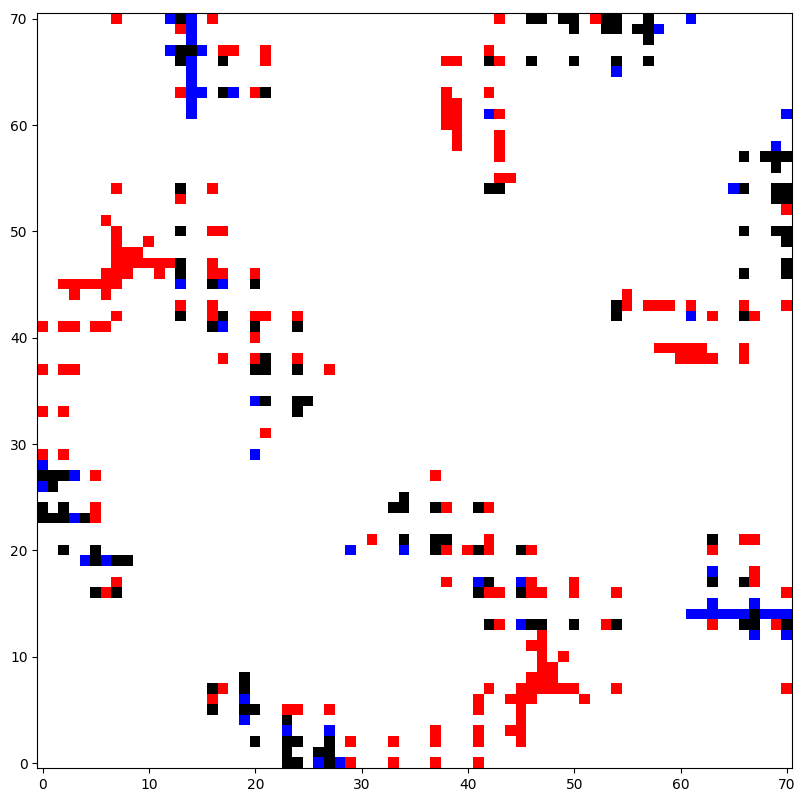

In [64]:
combined = data_native + data_predicted * 2
from matplotlib import colors
# white means not present in both
# red means present in the first but not the second
# blue means present in the second but not the first
# black means present in both
cmap = colors.ListedColormap(['white', 'red', 'blue', 'black'])
bounds=[-1,0.1, 1.1, 2.1, 3.1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.imshow(combined, origin="bottom", cmap=cmap, norm=norm)

In [56]:
pdbFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_run/iteration_start_native_iter5/1baj/0/native.pdb"
seq = read_fasta("/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/1baj/crystal_structure.fasta")
frame_index = 0
cutoff = 9.5
MAX_OFFSET = 9
parser = PDBParser()
structure = parser.get_structure("x", pdbFile)
models = list(structure.get_models())
model = models[frame_index]
all_residues = list(model.get_residues())
n = len(all_residues)
contact_table = np.zeros((n,n))
# print(pdb, n)#
for i, res1 in enumerate(all_residues):
    if seq[i] == "G":
        a1 = res1["CA"]
    else:
        a1 = res1["CB"]
    for j, res2 in enumerate(all_residues):
        if seq[j] == "G":
            a2 = res2["CA"]
        else:
            a2 = res2["CB"]
        contact_table[i][j] = a1 - a2

data = (contact_table < cutoff)
remove_band = np.eye(n)
for i in range(1, MAX_OFFSET):
    remove_band += np.eye(n, k=i)
    remove_band += np.eye(n, k=-i)
data[remove_band==1] = 0

[<Model id=0>, <Model id=1>]

In [23]:
three_to_one("TRP")

'W'

In [25]:
seq.count("W")

1

In [ ]:
pdbFile = "/Users/weilu/Research/server/mar_2020/mass_iterative_run/setups/1baj/cbd-openmmawsem.pdb"

cutoff = 9.5
MAX_OFFSET = 9
parser = PDBParser()
structure = parser.get_structure("x", pdbFile)
all_residues = list(structure.get_residues())
n = len(all_residues)
contact_table = np.zeros((n,n))
# print(pdb, n)#
for i, res1 in enumerate(all_residues):
    for j, res2 in enumerate(all_residues):
        contact_table[i][j] = res1["CA"]-res2["CA"]

data = (contact_table < cutoff)
remove_band = np.eye(n)
for i in range(1, MAX_OFFSET):
    remove_band += np.eye(n, k=i)
    remove_band += np.eye(n, k=-i)
data[remove_band==1] = 0
data_ca = data

In [11]:
fileLocation = "/Users/weilu/Research/server/feb_2020/SPOT-Contact-Helical-New/outputs/tmp.spotcon"
data = pd.read_csv(fileLocation, skiprows=5, sep="\s+", names=["i","j","p"]).dropna().reset_index(drop=True)

data["i"] = data["i"].astype(int)
data["j"] = data["j"].astype(int)
data_A = data

In [12]:
fileLocation = "/Users/weilu/Research/server/feb_2020/SPOT-Contact-Helical-New/outputs/original.spotcon"
data = pd.read_csv(fileLocation, skiprows=5, sep="\s+", names=["i","j","p"]).dropna().reset_index(drop=True)

data["i"] = data["i"].astype(int)
data["j"] = data["j"].astype(int)
data_original = data

/Users/weilu/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
data_original.dtypes

i      int64
j      int64
p    float64
dtype: object

In [15]:
data_A.dtypes

i      int64
j      int64
p    float64
dtype: object

In [17]:
seq = "MSKLTTGSFSIEDLESVQITINNIVGAAKEAAEEKEKELVNAGPTLFPGLEGYRDDWNFKLLDRYEPVITPMCDQCCYCTYGPCDLSGNKRGACGIDMKGHNGREFFLRVITGTACHAAHGRHLLDHLIEKYGEDLPLTLGQSNVLTPNITISTGLSPKTLGEVKPAMEYVEEQLTQLLATVHAGQESAEIDYDSKALFSGSLDHVGMEISDIVQVAAYDFPKADPEAPLVEIGMGTIDKSKPFLCVIGHNVAGVTYMMDYMEDNNLTDKMEIAGLCCTAIDLTRYKEADRRPPYAKVIGSMSKELKVIRSGMPDVIVVDEQCVRGDIVPEAQKLKIPVIASNPKIMYGLPNRTDADVDETMEELKSGKIPGCVMLDYDKLGELCVRLTMEMAPIRDAAGITALPTDEELVNMVAKCADCGACLLACPEEIDIPEAMGFAKKGDFSYFEEIHDTCIGCRRCEQVCKKEIPILNVIEKIAQKQIAEEKGLMRAGRGQVSDAEIRAEGLNLVMGTTPGIIAIIGCPNYAGGTKDVYYIAEEFLKRNFIVVTTGCGAMDIGMFKDADGKTLYERFPGGFQCGGLANIGSCVSNAHITGAAEKVAAIFAQRTLEGNLAEIGDYILNRVGACGLAWGAFSQKASSIGTGCNIFGIPAVLGPHSSKYRRALIAKTYEEDKWKVYDARNGQEMPIPPAPEFLLTTAETWQEAIPMMAKACIRPSDNSMGRAIKLTHWMELHKKYLGGKEPEDWWKFVRTEADLPLATREALLKELEKEHGWEIDWKRKKIISGPKIKFDVSAQPTNLKRLCKEA"

In [18]:
len(seq)

807

In [33]:
seq

'MSKLTTGSFSIEDLESVQITINNIVGAAKEAAEEKEKELVNAGPTLFPGLEGYRDDWNFKLLDRYEPVITPMCDQCCYCTYGPCDLSGNKRGACGIDMKGHNGREFFLRVITGTACHAAHGRHLLDHLIEKYGEDLPLTLGQSNVLTPNITISTGLSPKTLGEVKPAMEYVEEQLTQLLATVHAGQESAEIDYDSKALFSGSLDHVGMEISDIVQVAAYDFPKADPEAPLVEIGMGTIDKSKPFLCVIGHNVAGVTYMMDYMEDNNLTDKMEIAGLCCTAIDLTRYKEADRRPPYAKVIGSMSKELKVIRSGMPDVIVVDEQCVRGDIVPEAQKLKIPVIASNPKIMYGLPNRTDADVDETMEELKSGKIPGCVMLDYDKLGELCVRLTMEMAPIRDAAGITALPTDEELVNMVAKCADCGACLLACPEEIDIPEAMGFAKKGDFSYFEEIHDTCIGCRRCEQVCKKEIPILNVIEKIAQKQIAEEKGLMRAGRGQVSDAEIRAEGLNLVMGTTPGIIAIIGCPNYAGGTKDVYYIAEEFLKRNFIVVTTGCGAMDIGMFKDADGKTLYERFPGGFQCGGLANIGSCVSNAHITGAAEKVAAIFAQRTLEGNLAEIGDYILNRVGACGLAWGAFSQKASSIGTGCNIFGIPAVLGPHSSKYRRALIAKTYEEDKWKVYDARNGQEMPIPPAPEFLLTTAETWQEAIPMMAKACIRPSDNSMGRAIKLTHWMELHKKYLGGKEPEDWWKFVRTEADLPLATREALLKELEKEHGWEIDWKRKKIISGPKIKFDVSAQPTNLKRLCKEA'

In [61]:
n = len(seq)
t = np.zeros((n,n))
for index, d in data_A.iterrows():
#     print(index)
    i = int(d["i"]) - 1
    j = int(d["j"]) - 1 
    p = d["p"]
#     print(i,j,p)
    t[i,j] = p
    t[j,i] = p


In [72]:
data_s = data.astype(int)
t_s = (t>0.08).astype(float)
combined = data_s + t_s * 2
from matplotlib import colors
cmap = colors.ListedColormap(['white', 'red', 'blue', 'black'])
bounds=[-1,0.1, 1.1, 2.1, 3.1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.imshow(combined, origin="bottom", cmap=cmap, norm=norm)

ValueError: operands could not be broadcast together with shapes (766,766) (807,807) 

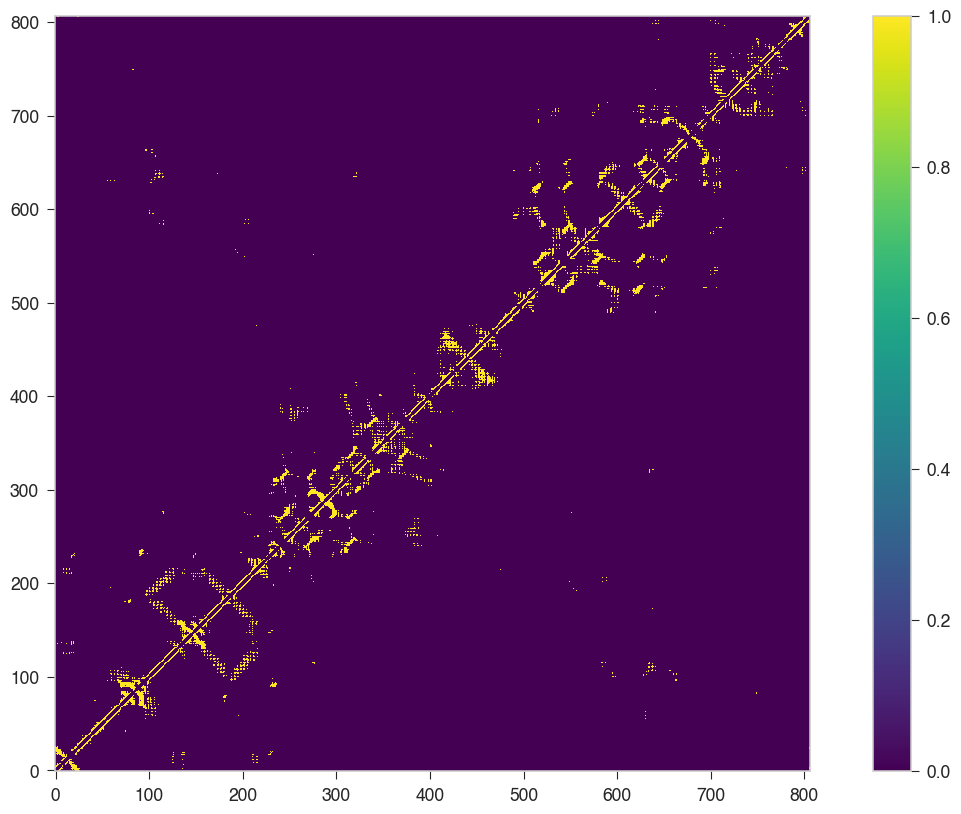

In [71]:
plt.imshow((t>0.08).astype(float), origin="bottom")
plt.colorbar()

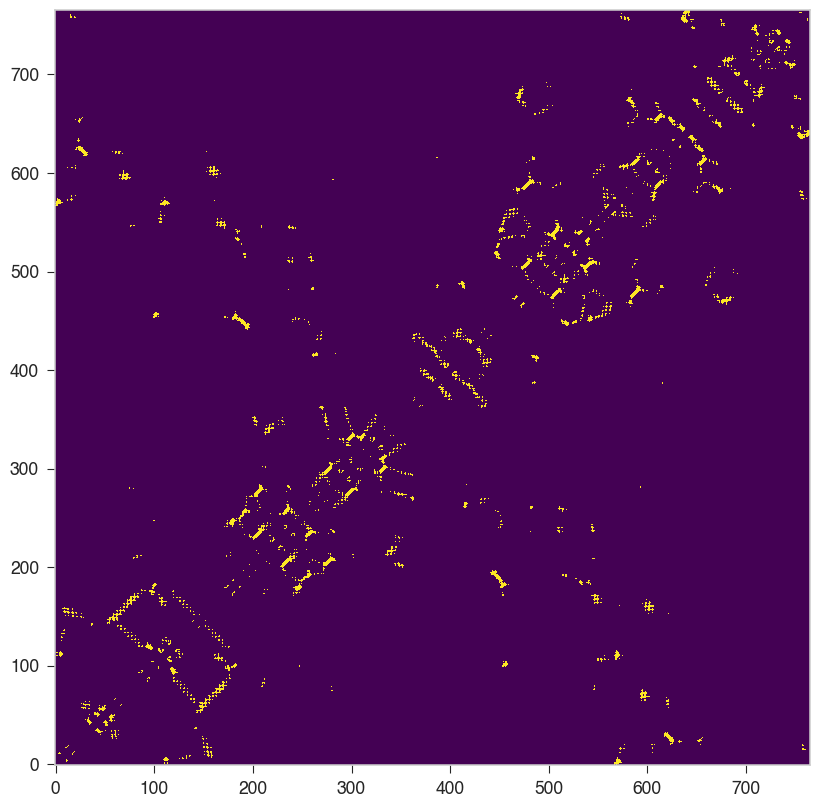

In [70]:
plt.imshow(data, origin="bottom")

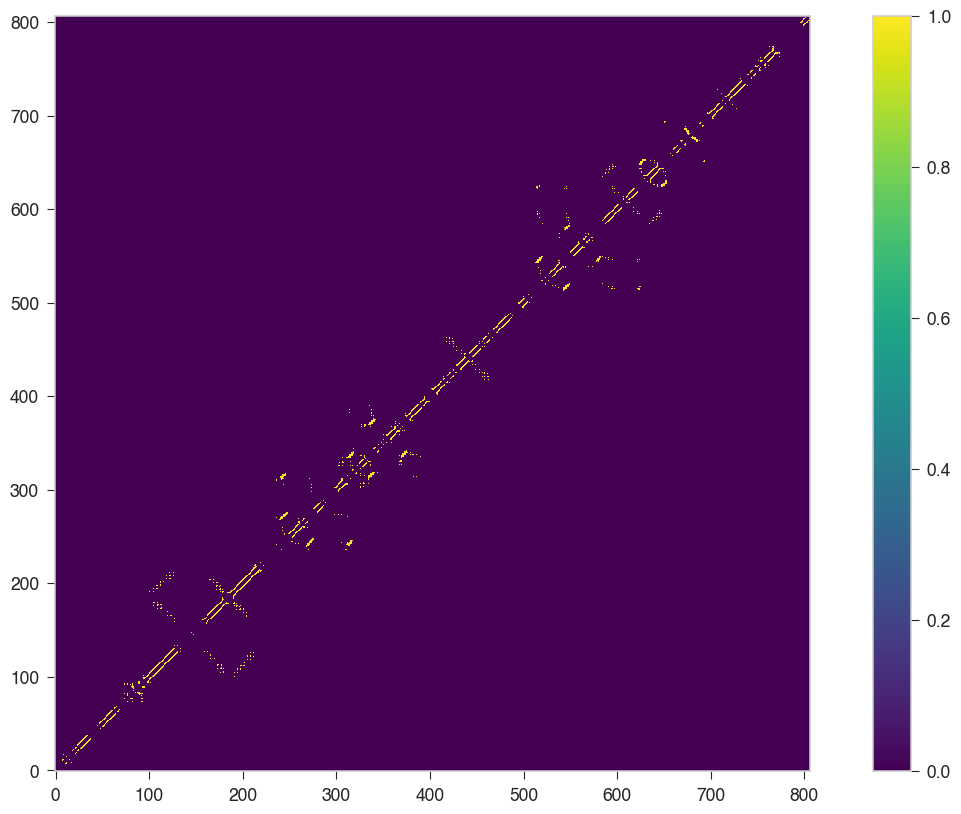

In [20]:
plt.imshow((t>0.5).astype(float), origin="bottom")
plt.colorbar()

In [21]:
n = len(seq)
t = np.zeros((n,n))
for index, d in data_original.iterrows():
#     print(index)
    i = int(d["i"]) - 1
    j = int(d["j"]) - 1 
    p = d["p"]
#     print(i,j,p)
    t[i,j] = p
    t[j,i] = p


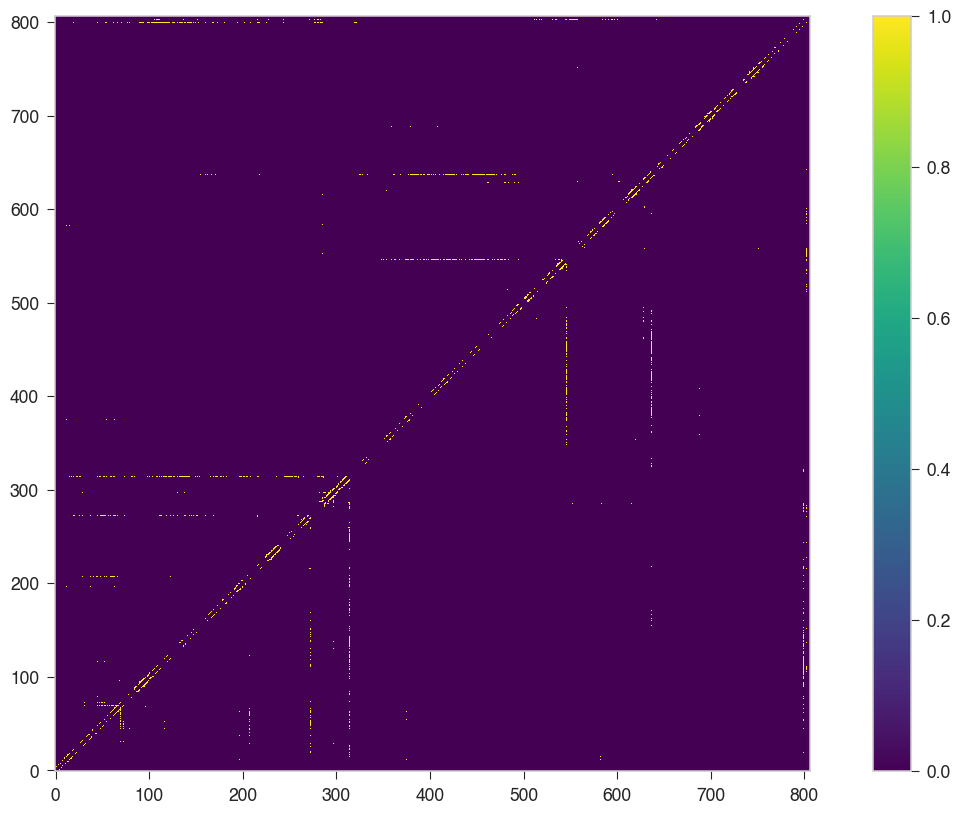

In [26]:
plt.imshow((t>0.1).astype(float), origin="bottom")
plt.colorbar()

In [7]:
len(a[5])

51

In [22]:
pdb = "4rws"
fileLocation = f"/Users/weilu/Research/raptorX/{pdb}/A.txt"
data = pd.read_csv(fileLocation, skiprows=6, sep="\s+", names=["i","j","s", "ss","p"]).dropna().reset_index(drop=True)
data["i"] = data["i"].astype(int)
data["j"] = data["j"].astype(int)
data_A = data
seq_A = getSeqFromRaptorXContact(fileLocation)

fileLocation = f"/Users/weilu/Research/raptorX/{pdb}/B.txt"
data = pd.read_csv(fileLocation, skiprows=6, sep="\s+", names=["i","j","s", "ss","p"]).dropna().reset_index(drop=True)
data["i"] = data["i"].astype(int)
data["j"] = data["j"].astype(int)
data_B = data
seq_B = getSeqFromRaptorXContact(fileLocation)


In [86]:
import textwrap
header = '''\
PFRMAT RR
TARGET {}
AUTHOR RaptorX-Contact
METHOD deep dilated residual networks (one variant of deep CNN). Consult jinboxu@gmail.com for details.
MODEL 1
'''
fileLocation = f"/Users/weilu/Research/raptorX/{pdb}/{pdb}.txt"
with open(fileLocation, "w") as out:
    out.write(header.format(pdb))
    out.write("\n".join(textwrap.wrap(seq, width=50))+"\n")
    for index, d in data_A.iterrows():
    #     print(index)
        i = int(d["i"])
        j = int(d["j"])
        p = round(d["p"], 8)
        s = int(d["s"])
        ss = int(d["ss"])
        out.write(f"{i} {j} {s} {ss} {p}\n")
    for index, d in data_B.iterrows():
    #     print(index)
        i = int(d["i"]) + len(seq_A)
        j = int(d["j"]) + len(seq_A)
        p = round(d["p"], 8)
        s = int(d["s"])
        ss = int(d["ss"])
        out.write(f"{i} {j} {s} {ss} {p}\n")
    out.write("END\n")

In [80]:
for index, d in data_B.iterrows():
#     print(index)
    i = int(d["i"]) - 1 + len(seq_A)
    j = int(d["j"]) - 1 + len(seq_A)
    p = round(d["p"], 8)
    s = int(d["s"])
    ss = int(d["ss"])

In [84]:
data_A

,i,j,s,ss,p
0,34,59,0.0,8.0,0.997731
1,38,56,0.0,8.0,0.980999
2,41,52,0.0,8.0,0.973823
3,38,59,0.0,8.0,0.966630
4,27,66,0.0,8.0,0.962626
5,34,62,0.0,8.0,0.961573
6,35,59,0.0,8.0,0.916884
7,41,55,0.0,8.0,0.895539
8,31,63,0.0,8.0,0.874988
9,30,62,0.0,8.0,0.842116


In [79]:
round(p, 8)

0.0023355

In [23]:
seq = seq_A + seq_B

In [26]:
seq

'SMKEPCFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQSMTDKYRLHLSVADLLFVITLPFWAVDAVANWYFGNFLCKAVHVIYTVNLYSSVWILAFISLDRYLAIVHATNSQRPRKLLAEKVVYVGVWIPALLLTIPDFIFANVSEADDRYICCRFYPNDLWVVVFQFQHIMVGLILPGIVILSCYCIIISKLSHSGHQKRKALKPTVILILAFFACWLPYYIGISIDSFILLEIIKQGCEFENTVHKWISITEALAFFHCCLNPILYALGASCHRPDKCCLGYQKRPLPQVLLSSWYPTSQLCSKPGVIFLTKRGRQVCADKSKDWVKKLMQQLPVTA'

In [27]:
n = len(seq)
t = np.zeros((n,n))
for index, d in data_A.iterrows():
#     print(index)
    i = int(d["i"]) - 1
    j = int(d["j"]) - 1 
    p = d["p"]
#     print(i,j,p)
    t[i,j] = p
    t[j,i] = p
for index, d in data_B.iterrows():
#     print(index)
    i = int(d["i"]) - 1 + len(seq_A)
    j = int(d["j"]) - 1 + len(seq_A)
    p = d["p"]
#     print(i,j,p)
    t[i,j] = p
    t[j,i] = p

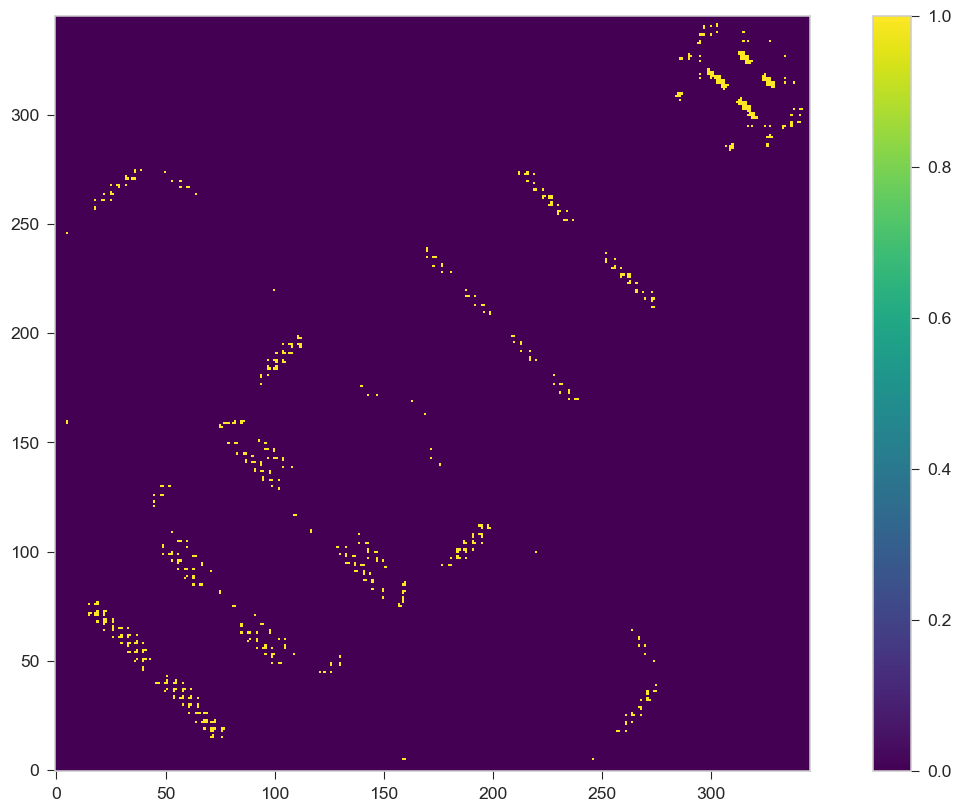

In [28]:
plt.imshow((t>0.5).astype(float), origin="bottom")
plt.colorbar()

In [29]:
def getSeqFromRaptorXContact(fileLocation):
    with open(fileLocation) as f:
        a = f.readlines()
    i = 4
    seq = ""
    assert a[i] == "MODEL 1\n"
    i += 1
    while True:
        line = a[i]
        if line[0].isdigit():
            break
        i += 1
        seq += line.strip()
    # print(i)
    return seq
def getContactMapFromPDB(pdbFile):
    cutoff = 9.5
    MAX_OFFSET = 6
    parser = PDBParser()
    structure = parser.get_structure('target', pdbFile)
    all_residues = list(structure.get_residues())
    n = len(all_residues)
    contact_table = np.zeros((n,n))
    # print(pdb, n)#
    for i, res1 in enumerate(all_residues):
        for j, res2 in enumerate(all_residues):
            contact_table[i][j] = res1["CA"]-res2["CA"]

    data = (contact_table < cutoff)
    remove_band = np.eye(n)
    for i in range(1, MAX_OFFSET):
        remove_band += np.eye(n, k=i)
        remove_band += np.eye(n, k=-i)
    data[remove_band==1] = 0
    return data

In [53]:
pdbFile = "/Users/weilu/Research/server/feb_2020/SPOT-Contact-Helical-New/outputs/3cf4_A.pdb"
cutoff = 9.5
MAX_OFFSET = 6
parser = PDBParser()
structure = parser.get_structure('target', pdbFile)
# chainA = structure[0]["A"]
# all_residues = list(chainA.get_residues())
all_residues = []
for res in structure.get_residues():
    if res.get_id()[0] == " ":
        all_residues.append(res)
n = len(all_residues)
contact_table = np.zeros((n,n))
# print(pdb, n)#
for i, res1 in enumerate(all_residues):
    for j, res2 in enumerate(all_residues):
        contact_table[i][j] = res1["CA"]-res2["CA"]

data = (contact_table < cutoff)
remove_band = np.eye(n)
for i in range(1, MAX_OFFSET):
    remove_band += np.eye(n, k=i)
    remove_band += np.eye(n, k=-i)
data[remove_band==1] = 0

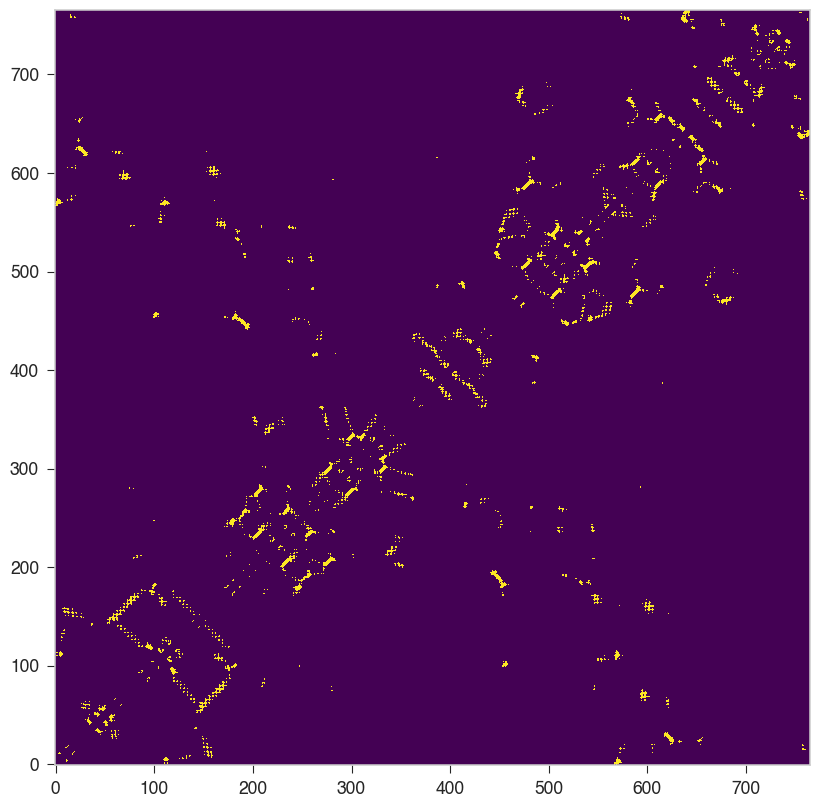

In [60]:
plt.imshow(data, origin="bottom")

In [58]:
data_s = data.astype(int)
t_s = (t>0.55).astype(float)

In [30]:
data = getContactMapFromPDB("/Users/weilu/Research/server/feb_2020/SPOT-Contact-Helical-New/outputs/3cf4.pdb")

/Users/weilu/anaconda3/envs/py36/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8106.
  PDBConstructionWarning,
/Users/weilu/anaconda3/envs/py36/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 8197.
  PDBConstructionWarning,
/Users/weilu/anaconda3/envs/py36/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8214.
  PDBConstructionWarning,
/Users/weilu/anaconda3/envs/py36/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 8653.
  PDBConstructionWarning,


KeyError: 'CA'

In [30]:
data = getContactMapFromPDB("/Users/weilu/Research/server/jul_2019/two_chains/cleaned_pdbs/4rws.pdb")

4rws 346


In [70]:
data_s = data.astype(int)
t_s = (t>0.55).astype(float)

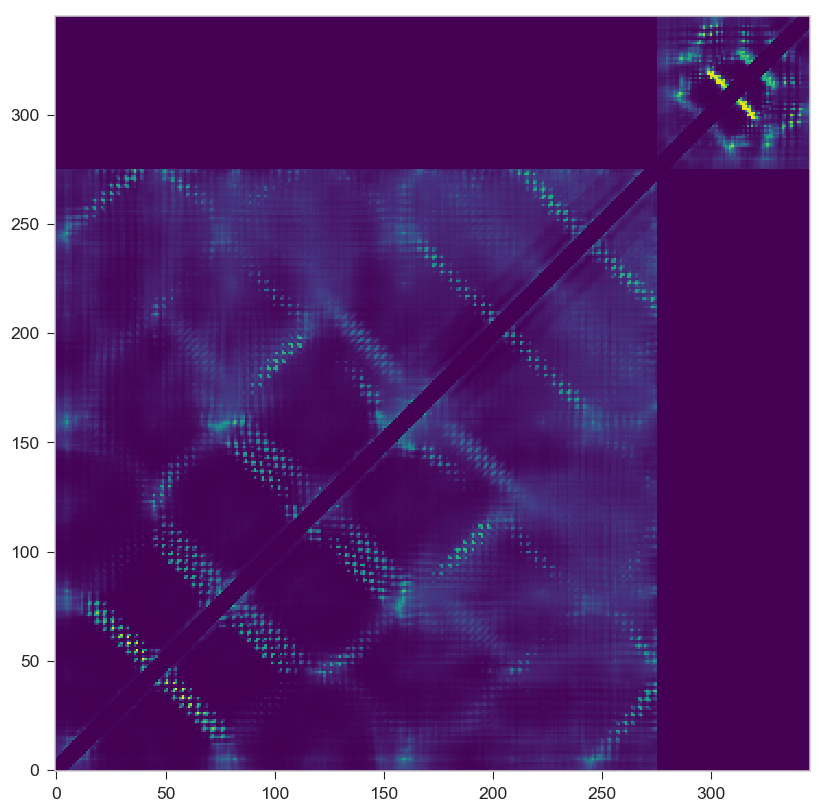

In [72]:
fig, ax = plt.subplots()
# ax.imshow(data_s+1, origin="bottom")
ax.imshow(t, origin="bottom")

In [60]:
combined = data_s + t_s * 2

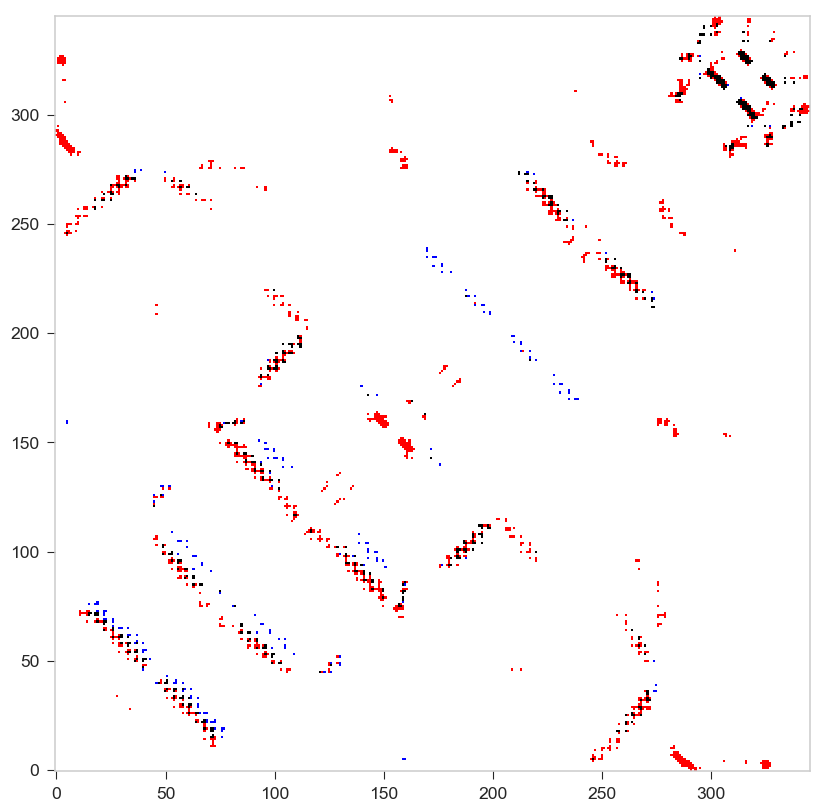

In [63]:
combined = data_s + t_s * 2
from matplotlib import colors
cmap = colors.ListedColormap(['white', 'red', 'blue', 'black'])
bounds=[-1,0.1, 1.1, 2.1, 3.1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.imshow(combined, origin="bottom", cmap=cmap, norm=norm)

In [87]:
pdbFile = "/Users/weilu/Research/server/jul_2019/two_chains/cleaned_pdbs/4rws.pdb"
parser = PDBParser()
structure = parser.get_structure('target', pdbFile)

In [88]:
model = structure[0]

In [90]:
a = list(model.get_chains())

In [92]:
c = a[0]

In [94]:
c.id

'A'

In [95]:
c = "ALL"

In [99]:
"ABC" is not "ALL"

True

In [93]:
c.get_id()

'A'

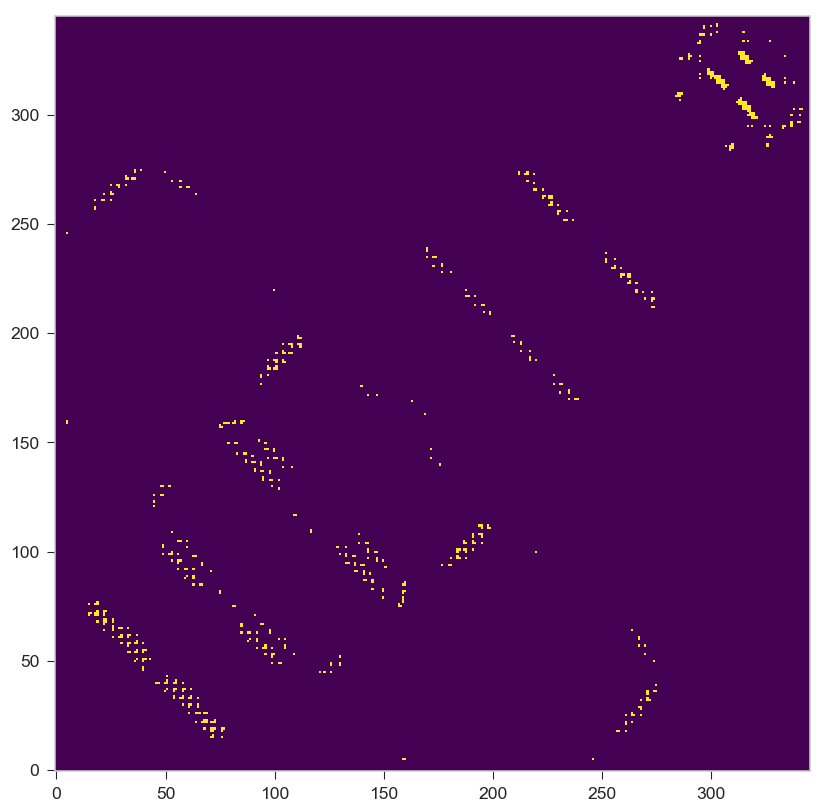

In [55]:
fig, ax = plt.subplots()
ax.imshow(data_s+1, origin="bottom")
ax.imshow(t_s, origin="bottom")

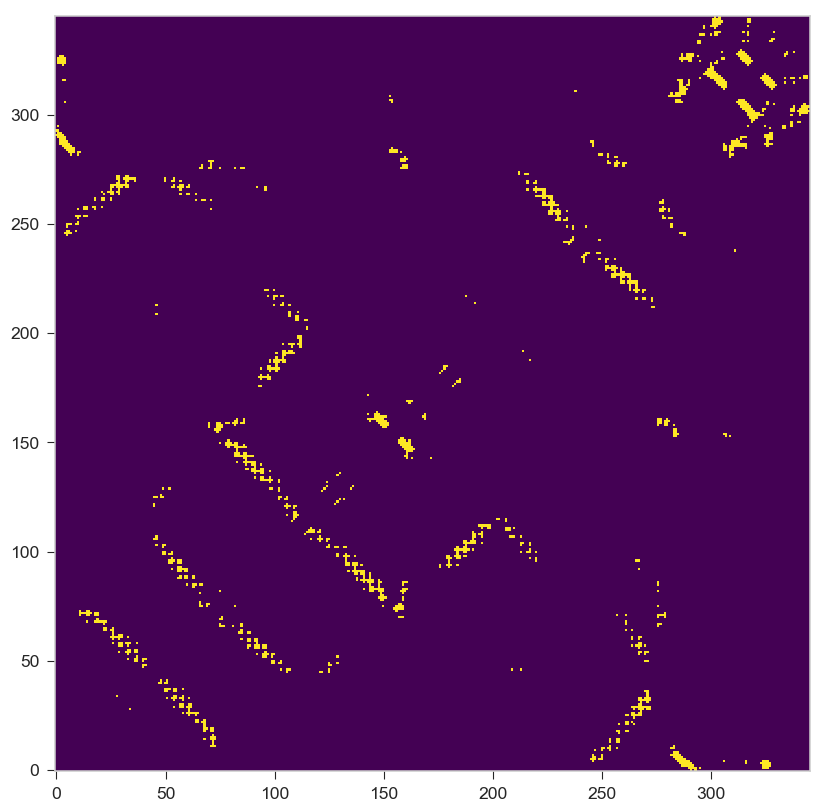

In [43]:
plt.imshow(data_s, origin="bottom")

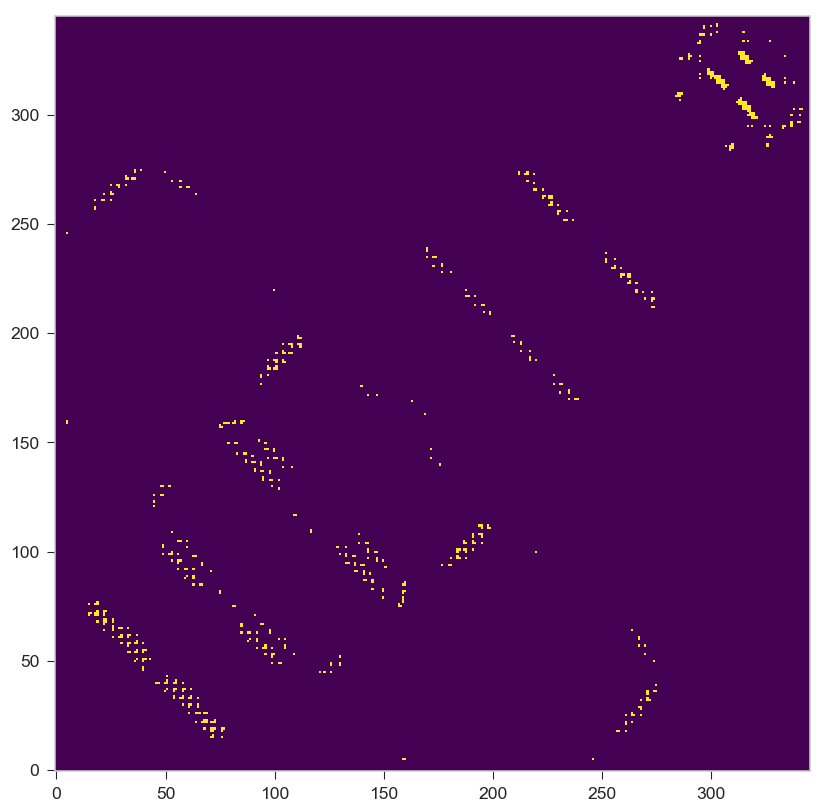

In [44]:
# plt.imshow(-data_s, origin="bottom")
plt.imshow(t_s, origin="bottom")
# plt.colorbar()

In [16]:
346

70

In [17]:
fileLocation = f"/Users/weilu/Research/raptorX/{pdb}/B.txt"

In [20]:
len(seq)

276

In [18]:
pdb = "4rws"
fileLocation = f"/Users/weilu/Research/raptorX/{pdb}/A.txt"
data = pd.read_csv(fileLocation, skiprows=6, sep="\s+", names=["i","j","s", "ss","p"]).dropna().reset_index(drop=True)
data["i"] = data["i"].astype(int)
data["j"] = data["j"].astype(int)
n = int(info.query(f"Protein =='{pdb}'")["Length"])
t = np.zeros((n,n))
for index, d in data.iterrows():
#     print(index)
    i = int(d["i"]) - 1
    j = int(d["j"]) - 1 
    p = d["p"]
#     print(i,j,p)
    t[i,j] = p
    t[j,i] = p

NameError: name 'info' is not defined

In [ ]:
def getContactMap(pdb):
    fileLocation = f"/Users/weilu/Research/raptorX/{pdb}/contactmap.txt"
    data = pd.read_csv(fileLocation, skiprows=6, sep="\s+", names=["i","j","s", "ss","p"]).dropna().reset_index(drop=True)
    data["i"] = data["i"].astype(int)
    data["j"] = data["j"].astype(int)
    n = int(info.query(f"Protein =='{pdb}'")["Length"])
    t = np.zeros((n,n))
    for index, d in data.iterrows():
    #     print(index)
        i = int(d["i"]) - 1
        j = int(d["j"]) - 1 
        p = d["p"]
    #     print(i,j,p)
        t[i,j] = p
        t[j,i] = p